In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'WBTC-USDC-3000'
MAX_DATE = '2022-01-28'
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_RETURNS = f'./saved-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59869 entries, 0 to 59868
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   swap_time                       59869 non-null  datetime64[ns, UTC]
 1   tx_hash                         59869 non-null  string             
 2   token_0_amount                  59869 non-null  float64            
 3   token_1_amount                  59869 non-null  float64            
 4   pool_address                    59869 non-null  string             
 5   price_tick                      59869 non-null  int64              
 6   price_tick_adjusted             59869 non-null  float64            
 7   contract_address_token_0        59869 non-null  string             
 8   contract_name_token_0           59869 non-null  string             
 9   contract_ticker_symbol_token_0  59869 non-null  string             
 10  contract_d

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:16:46+00:00,0xefb6c69ebc8f3c4fddd76285fcab762bad87f76e2711...,-3.954100,149915.227680,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59358,37823.028503,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
1,2022-01-29 19:15:23+00:00,0xb8dfaa80fc9d3eef699d82c12efe5d8af461850b7fdf...,-0.867346,32860.000005,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59345,37773.892968,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
2,2022-01-29 18:57:13+00:00,0xf425d531045993eb8d366ea67982805eba019f02e3c2...,-1.056121,40000.000000,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59343,37766.339322,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
3,2022-01-29 18:50:50+00:00,0xea8be1860e6a79044e77e7eadaeddfacebd518a878a5...,-5.947671,225024.000000,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59339,37751.236563,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
4,2022-01-29 18:23:26+00:00,0x74080f03033e03f829265b4943338886d4f6f85c0bf5...,-0.072087,2724.828817,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59321,37683.348848,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        10876 non-null  datetime64[ns, UTC]
 1   tx_hash                         10876 non-null  string             
 2   token_0_amount                  10876 non-null  float64            
 3   token_1_amount                  10876 non-null  float64            
 4   pool_address                    10876 non-null  string             
 5   liquidity_event                 10876 non-null  string             
 6   price_tick_lower                10876 non-null  int64              
 7   price_tick_upper                10876 non-null  int64              
 8   price_tick_lower_adjusted       10876 non-null  float64            
 9   price_tick_upper_adjusted       10876 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 14:34:45+00:00,0x5574ae4a7e7eca2d2a9b46d9f8d1dd249a7b149443b1...,0.000000,0.000000e+00,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,REMOVE_LIQUIDITY,58380,60660,34299.234168,43082.273604,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Burn,3000,60,2021-05-05 19:13:15+00:00,-0.000000e+00
1,2022-01-29 14:34:45+00:00,0x5574ae4a7e7eca2d2a9b46d9f8d1dd249a7b149443b1...,0.000000,0.000000e+00,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,REMOVE_LIQUIDITY,58380,59520,34299.234168,38440.720478,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Burn,3000,60,2021-05-05 19:13:15+00:00,-0.000000e+00
2,2022-01-29 11:49:52+00:00,0x10e9d01f3880655734f19a9926ea6c7309d7705e954a...,0.013782,4.999998e+02,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,54060,64800,22267.865384,65175.975598,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,3000,60,2021-05-05 19:13:15+00:00,1.115092e-10
3,2022-01-29 10:14:33+00:00,0x97118fcde8fa493dba2c63fe983f990c40998a4d61b0...,82.654222,1.481778e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,58020,62160,33086.482866,50054.085346,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,3000,60,2021-05-05 19:13:15+00:00,1.212369e-06
4,2022-01-29 05:59:07+00:00,0xefb7032971be18fdaa23b7bc732fcffbcf3a72e06160...,29.276980,1.431584e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,REMOVE_LIQUIDITY,55200,62460,24956.615202,51578.381825,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Burn,3000,60,2021-05-05 19:13:15+00:00,-3.939689e-07


In [6]:
# looks like liquidity for this pool uses 8 decimal places rather than 18
liquidity['liquidity'] = liquidity['liquidity'] * 1e+10

In [7]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-05 19:13:15+00:00,0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb6...,0.011928,7.241840e+02,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,62160,64800,50054.085346,65175.975598,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,3000,60,2021-05-05 19:13:15+00:00,4.603874
1,2021-05-05 21:06:32+00:00,0x602034e50383895947441bf36b1c09784c333e1ff67f...,74.367447,4.219059e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,59940,67140,40089.530963,82358.299055,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,IncreaseLiquidity,3000,60,2021-05-05 19:13:15+00:00,10753.609507
2,2021-05-05 21:24:47+00:00,0xf63a954ff144da57e15c339fab9a37656cddf09a424b...,66.280753,3.743677e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,55200,71940,24956.615202,133093.944831,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,3000,60,2021-05-05 19:13:15+00:00,4606.710099
3,2021-05-05 22:47:55+00:00,0x3956908e039c4ca68d573678d3842bf7729f182daf05...,0.098023,3.942920e+03,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,61200,66840,45472.553647,79924.363347,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,3000,60,2021-05-05 19:13:15+00:00,15.216602
4,2021-05-05 22:53:01+00:00,0xc7d78c39089f8bed2286a64ad6e09774d5f70af9aa14...,0.013167,7.156860e+02,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,62340,64800,50963.170653,65175.975598,...,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,IncreaseLiquidity,3000,60,2021-05-05 19:13:15+00:00,5.148812


In [8]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb633156a60d81055a352eb


In [9]:
# from https://etherscan.io/tx/0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb633156a60d81055a352eb#eventlog
liquidity_delta = amount_to_float('460387401', 8)  # this pool uses 8 decimals for liquidity (adjusted above)
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (USDC/WBTC): 5.733993536946e+02
Pool initial price (WBTC/USDC): 1.743985223486e-03


In [10]:
sqrt_price_x96 = 1897178451720590875109406646877
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 5.733993536946e+02
Price per Etherscan:      5.733993536192e+02


In [11]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,10875,0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb6...,2021-05-05 19:13:15+00:00,ADD_LIQUIDITY
1,10874,0x602034e50383895947441bf36b1c09784c333e1ff67f...,2021-05-05 21:06:32+00:00,ADD_LIQUIDITY
2,59868,0xf50dd2ad40e841f3a75dbe9bd113a0beb457e9c60ae2...,2021-05-05 21:08:03+00:00,SWAP
3,59867,0xc6e7241ce2254b9082f1c89a335be138d3d55c526d8e...,2021-05-05 21:08:23+00:00,SWAP
4,59866,0xddd29d5a777047bb81c5824450b04bef9a18e96df1f2...,2021-05-05 21:12:44+00:00,SWAP
...,...,...,...,...
70472,262,0x9dcb82483c60afbc11cb9a08a109b8e36bea6c0eb9c2...,2022-01-27 23:31:25+00:00,SWAP
70473,261,0x3c719b85571c54b1172fdf64ea9b5a2366a06c6eace1...,2022-01-27 23:32:31+00:00,SWAP
70474,260,0x4e1e094c760ed85cfc9b4338b8813ad6de56a4d437a1...,2022-01-27 23:45:57+00:00,SWAP
70475,259,0xf702963243984842e1e8fa6f44c831298d894faef449...,2022-01-27 23:53:43+00:00,SWAP


In [12]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-8, 'rtol': 1e-5}
TOKEN1_TOLS = {'atol': 1e-8, 'rtol': 1e-5}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [13]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

Pool(price=57,339.9354, liquidity=0.00, fee=0.30%)
Completed transaction 0.
Completed transaction 1.
Completed transaction 2.
Completed transaction 3.
Completed transaction 4.
Completed transaction 5.
Completed transaction 6.
Completed transaction 7.
Completed transaction 8.
Completed transaction 9.
Completed transaction 10.
Completed transaction 11.
Completed transaction 12.
Completed transaction 13.
Completed transaction 14.
Completed transaction 15.
Completed transaction 16.
Completed transaction 17.
Completed transaction 18.
Completed transaction 19.
Completed transaction 20.
Completed transaction 21.
Completed transaction 22.
Completed transaction 23.
Completed transaction 24.
Completed transaction 25.
Completed transaction 26.
Completed transaction 27.
Completed transaction 28.
Completed transaction 29.
Completed transaction 30.
Completed transaction 31.
Completed transaction 32.
Completed transaction 33.
Completed transaction 34.
Completed transaction 35.
Completed transaction 3

Completed transaction 491.
Completed transaction 492.
Completed transaction 493.
Completed transaction 494.
Completed transaction 495.
Completed transaction 496.
Completed transaction 497.
Completed transaction 498.
Completed transaction 499.
Completed transaction 500.
Completed transaction 501.
Completed transaction 502.
Completed transaction 503.
Completed transaction 504.
Completed transaction 505.
Completed transaction 506.
Completed transaction 507.
Completed transaction 508.
Completed transaction 509.
Completed transaction 510.
Completed transaction 511.
Completed transaction 512.
Completed transaction 513.
Completed transaction 514.
Completed transaction 515.
Completed transaction 516.
Completed transaction 517.
Completed transaction 518.
Completed transaction 519.
Completed transaction 520.
Completed transaction 521.
Completed transaction 522.
Completed transaction 523.
Completed transaction 524.
Completed transaction 525.
Completed transaction 526.
Completed transaction 527.
C

Completed transaction 973.
Completed transaction 974.
Completed transaction 975.
Completed transaction 976.
Completed transaction 977.
Completed transaction 978.
Completed transaction 979.
Completed transaction 980.
Completed transaction 981.
Completed transaction 982.
Completed transaction 983.
Completed transaction 984.
Completed transaction 985.
Completed transaction 986.
Completed transaction 987.
Completed transaction 988.
Completed transaction 989.
Completed transaction 990.
Completed transaction 991.
Completed transaction 992.
Completed transaction 993.
Completed transaction 994.
Completed transaction 995.
Completed transaction 996.
Completed transaction 997.
Completed transaction 998.
Completed transaction 999.
Completed transaction 1000.
Completed transaction 1001.
Completed transaction 1002.
Completed transaction 1003.
Completed transaction 1004.
Completed transaction 1005.
Completed transaction 1006.
Completed transaction 1007.
Completed transaction 1008.
Completed transacti

Completed transaction 1486.
Completed transaction 1487.
Completed transaction 1488.
Completed transaction 1489.
Completed transaction 1490.
Completed transaction 1491.
Completed transaction 1492.
Completed transaction 1493.
Completed transaction 1494.
Completed transaction 1495.
Completed transaction 1496.
Completed transaction 1497.
Completed transaction 1498.
Completed transaction 1499.
Completed transaction 1500.
Completed transaction 1501.
Completed transaction 1502.
Completed transaction 1503.
Completed transaction 1504.
Completed transaction 1505.
Completed transaction 1506.
Completed transaction 1507.
Completed transaction 1508.
Completed transaction 1509.
Completed transaction 1510.
Completed transaction 1511.
Completed transaction 1512.
Completed transaction 1513.
Completed transaction 1514.
Completed transaction 1515.
Completed transaction 1516.
Completed transaction 1517.
Completed transaction 1518.
Completed transaction 1519.
Completed transaction 1520.
Completed transactio

Completed transaction 2041.
Completed transaction 2042.
Completed transaction 2043.
Completed transaction 2044.
Completed transaction 2045.
Completed transaction 2046.
Completed transaction 2047.
Completed transaction 2048.
Completed transaction 2049.
Completed transaction 2050.
Completed transaction 2051.
Completed transaction 2052.
Completed transaction 2053.
Completed transaction 2054.
Completed transaction 2055.
Completed transaction 2056.
Completed transaction 2057.
Completed transaction 2058.
Completed transaction 2059.
Completed transaction 2060.
Completed transaction 2061.
Completed transaction 2062.
Completed transaction 2063.
Completed transaction 2064.
Completed transaction 2065.
Completed transaction 2066.
Completed transaction 2067.
Completed transaction 2068.
Completed transaction 2069.
Completed transaction 2070.
Completed transaction 2071.
Completed transaction 2072.
Completed transaction 2073.
Completed transaction 2074.
Completed transaction 2075.
Completed transactio

Completed transaction 2444.
Completed transaction 2445.
Completed transaction 2446.
Completed transaction 2447.
Completed transaction 2448.
Completed transaction 2449.
Completed transaction 2450.
Completed transaction 2451.
Completed transaction 2452.
Completed transaction 2453.
Completed transaction 2454.
Completed transaction 2455.
Completed transaction 2456.
Completed transaction 2457.
Completed transaction 2458.
Completed transaction 2459.
Completed transaction 2460.
Completed transaction 2461.
Completed transaction 2462.
Completed transaction 2463.
Completed transaction 2464.
Completed transaction 2465.
Completed transaction 2466.
Completed transaction 2467.
Completed transaction 2468.
Completed transaction 2469.
Completed transaction 2470.
Completed transaction 2471.
Completed transaction 2472.
Completed transaction 2473.
Completed transaction 2474.
Completed transaction 2475.
Completed transaction 2476.
Completed transaction 2477.
Completed transaction 2478.
Completed transactio

Completed transaction 2987.
Completed transaction 2988.
Completed transaction 2989.
Completed transaction 2990.
Completed transaction 2991.
Completed transaction 2992.
Completed transaction 2993.
Completed transaction 2994.
Completed transaction 2995.
Completed transaction 2996.
Completed transaction 2997.
Completed transaction 2998.
Completed transaction 2999.
Completed transaction 3000.
Completed transaction 3001.
Completed transaction 3002.
Completed transaction 3003.
Completed transaction 3004.
Completed transaction 3005.
Completed transaction 3006.
Completed transaction 3007.
Completed transaction 3008.
Completed transaction 3009.
Completed transaction 3010.
Completed transaction 3011.
Completed transaction 3012.
Completed transaction 3013.
Completed transaction 3014.
Completed transaction 3015.
Completed transaction 3016.
Completed transaction 3017.
Completed transaction 3018.
Completed transaction 3019.
Completed transaction 3020.
Completed transaction 3021.
Completed transactio

Completed transaction 3462.
Completed transaction 3463.
Completed transaction 3464.
Completed transaction 3465.
Completed transaction 3466.
Completed transaction 3467.
Completed transaction 3468.
Completed transaction 3469.
Completed transaction 3470.
Completed transaction 3471.
Completed transaction 3472.
Completed transaction 3473.
Completed transaction 3474.
Completed transaction 3475.
Completed transaction 3476.
Completed transaction 3477.
Completed transaction 3478.
Completed transaction 3479.
Completed transaction 3480.
Completed transaction 3481.
Completed transaction 3482.
Completed transaction 3483.
Completed transaction 3484.
Completed transaction 3485.
Completed transaction 3486.
Completed transaction 3487.
Completed transaction 3488.
Completed transaction 3489.
Completed transaction 3490.
Completed transaction 3491.
Completed transaction 3492.
Completed transaction 3493.
Completed transaction 3494.
Completed transaction 3495.
Completed transaction 3496.
Completed transactio

Completed transaction 3986.
Completed transaction 3987.
Completed transaction 3988.
Completed transaction 3989.
Completed transaction 3990.
Completed transaction 3991.
Completed transaction 3992.
Completed transaction 3993.
Completed transaction 3994.
Completed transaction 3995.
Completed transaction 3996.
Completed transaction 3997.
Completed transaction 3998.
Completed transaction 3999.
Completed transaction 4000.
Completed transaction 4001.
Completed transaction 4002.
Completed transaction 4003.
Completed transaction 4004.
Completed transaction 4005.
Completed transaction 4006.
Completed transaction 4007.
Completed transaction 4008.
Completed transaction 4009.
Completed transaction 4010.
Completed transaction 4011.
Completed transaction 4012.
Completed transaction 4013.
Completed transaction 4014.
Completed transaction 4015.
Completed transaction 4016.
Completed transaction 4017.
Completed transaction 4018.
Completed transaction 4019.
Completed transaction 4020.
Completed transactio

Completed transaction 4479.
Completed transaction 4480.
Completed transaction 4481.
Completed transaction 4482.
Completed transaction 4483.
Completed transaction 4484.
Completed transaction 4485.
Completed transaction 4486.
Completed transaction 4487.
Completed transaction 4488.
Completed transaction 4489.
Completed transaction 4490.
Completed transaction 4491.
Completed transaction 4492.
Completed transaction 4493.
Completed transaction 4494.
Completed transaction 4495.
Completed transaction 4496.
Completed transaction 4497.
Completed transaction 4498.
Completed transaction 4499.
Completed transaction 4500.
Completed transaction 4501.
Completed transaction 4502.
Completed transaction 4503.
Completed transaction 4504.
Completed transaction 4505.
Completed transaction 4506.
Completed transaction 4507.
Completed transaction 4508.
Completed transaction 4509.
Completed transaction 4510.
Completed transaction 4511.
Completed transaction 4512.
Completed transaction 4513.
Completed transactio

Completed transaction 4955.
Completed transaction 4956.
Completed transaction 4957.
Completed transaction 4958.
Completed transaction 4959.
Completed transaction 4960.
Completed transaction 4961.
Completed transaction 4962.
Completed transaction 4963.
Completed transaction 4964.
Completed transaction 4965.
Completed transaction 4966.
Completed transaction 4967.
Completed transaction 4968.
Completed transaction 4969.
Completed transaction 4970.
Completed transaction 4971.
Completed transaction 4972.
Completed transaction 4973.
Completed transaction 4974.
Completed transaction 4975.
Completed transaction 4976.
Completed transaction 4977.
Completed transaction 4978.
Completed transaction 4979.
Completed transaction 4980.
Completed transaction 4981.
Completed transaction 4982.
Completed transaction 4983.
Completed transaction 4984.
Completed transaction 4985.
Completed transaction 4986.
Completed transaction 4987.
Completed transaction 4988.
Completed transaction 4989.
Completed transactio

Completed transaction 5414.
Completed transaction 5415.
Completed transaction 5416.
Completed transaction 5417.
Completed transaction 5418.
Completed transaction 5419.
Completed transaction 5420.
Completed transaction 5421.
Completed transaction 5422.
Completed transaction 5423.
Completed transaction 5424.
Completed transaction 5425.
Completed transaction 5426.
Completed transaction 5427.
Completed transaction 5428.
Completed transaction 5429.
Completed transaction 5430.
Completed transaction 5431.
Completed transaction 5432.
Completed transaction 5433.
Completed transaction 5434.
Completed transaction 5435.
Completed transaction 5436.
Completed transaction 5437.
Completed transaction 5438.
Completed transaction 5439.
Completed transaction 5440.
Completed transaction 5441.
Completed transaction 5442.
Completed transaction 5443.
Completed transaction 5444.
Completed transaction 5445.
Completed transaction 5446.
Completed transaction 5447.
Completed transaction 5448.
Completed transactio

Completed transaction 5869.
Completed transaction 5870.
Completed transaction 5871.
Completed transaction 5872.
Completed transaction 5873.
Completed transaction 5874.
Completed transaction 5875.
Completed transaction 5876.
Completed transaction 5877.
Completed transaction 5878.
Completed transaction 5879.
Completed transaction 5880.
Completed transaction 5881.
Completed transaction 5882.
Completed transaction 5883.
Completed transaction 5884.
Completed transaction 5885.
Completed transaction 5886.
Completed transaction 5887.
Completed transaction 5888.
Completed transaction 5889.
Completed transaction 5890.
Completed transaction 5891.
Completed transaction 5892.
Completed transaction 5893.
Completed transaction 5894.
Completed transaction 5895.
Completed transaction 5896.
Completed transaction 5897.
Completed transaction 5898.
Completed transaction 5899.
Completed transaction 5900.
Completed transaction 5901.
Completed transaction 5902.
Completed transaction 5903.
Completed transactio

Completed transaction 6249.
Completed transaction 6250.
Completed transaction 6251.
Completed transaction 6252.
Completed transaction 6253.
Completed transaction 6254.
Completed transaction 6255.
Completed transaction 6256.
Completed transaction 6257.
Completed transaction 6258.
Completed transaction 6259.
Completed transaction 6260.
Completed transaction 6261.
Completed transaction 6262.
Completed transaction 6263.
Completed transaction 6264.
Completed transaction 6265.
Completed transaction 6266.
Completed transaction 6267.
Completed transaction 6268.
Completed transaction 6269.
Completed transaction 6270.
Completed transaction 6271.
Completed transaction 6272.
Completed transaction 6273.
Completed transaction 6274.
Completed transaction 6275.
Completed transaction 6276.
Completed transaction 6277.
Completed transaction 6278.
Completed transaction 6279.
Completed transaction 6280.
Completed transaction 6281.
Completed transaction 6282.
Completed transaction 6283.
Completed transactio

Completed transaction 6577.
Completed transaction 6578.
Completed transaction 6579.
Completed transaction 6580.
Completed transaction 6581.
Completed transaction 6582.
Completed transaction 6583.
Completed transaction 6584.
Completed transaction 6585.
Completed transaction 6586.
Completed transaction 6587.
Completed transaction 6588.
Completed transaction 6589.
Completed transaction 6590.
Completed transaction 6591.
Completed transaction 6592.
Completed transaction 6593.
Completed transaction 6594.
Completed transaction 6595.
Completed transaction 6596.
Completed transaction 6597.
Completed transaction 6598.
Completed transaction 6599.
Completed transaction 6600.
Completed transaction 6601.
Completed transaction 6602.
Completed transaction 6603.
Completed transaction 6604.
Completed transaction 6605.
Completed transaction 6606.
Completed transaction 6607.
Completed transaction 6608.
Completed transaction 6609.
Completed transaction 6610.
Completed transaction 6611.
Completed transactio

Completed transaction 7025.
Completed transaction 7026.
Completed transaction 7027.
Completed transaction 7028.
Completed transaction 7029.
Completed transaction 7030.
Completed transaction 7031.
Completed transaction 7032.
Completed transaction 7033.
Completed transaction 7034.
Completed transaction 7035.
Completed transaction 7036.
Completed transaction 7037.
Completed transaction 7038.
Completed transaction 7039.
Completed transaction 7040.
Completed transaction 7041.
Completed transaction 7042.
Completed transaction 7043.
Completed transaction 7044.
Completed transaction 7045.
Completed transaction 7046.
Completed transaction 7047.
Completed transaction 7048.
Completed transaction 7049.
Completed transaction 7050.
Completed transaction 7051.
Completed transaction 7052.
Completed transaction 7053.
Completed transaction 7054.
Completed transaction 7055.
Completed transaction 7056.
Completed transaction 7057.
Completed transaction 7058.
Completed transaction 7059.
Completed transactio

Completed transaction 7455.
Completed transaction 7456.
Completed transaction 7457.
Completed transaction 7458.
Completed transaction 7459.
Completed transaction 7460.
Completed transaction 7461.
Completed transaction 7462.
Completed transaction 7463.
Completed transaction 7464.
Completed transaction 7465.
Completed transaction 7466.
Completed transaction 7467.
Completed transaction 7468.
Completed transaction 7469.
Completed transaction 7470.
Completed transaction 7471.
Completed transaction 7472.
Completed transaction 7473.
Completed transaction 7474.
Completed transaction 7475.
Completed transaction 7476.
Completed transaction 7477.
Completed transaction 7478.
Completed transaction 7479.
Completed transaction 7480.
Completed transaction 7481.
Completed transaction 7482.
Completed transaction 7483.
Completed transaction 7484.
Completed transaction 7485.
Completed transaction 7486.
Completed transaction 7487.
Completed transaction 7488.
Completed transaction 7489.
Completed transactio

Completed transaction 7946.
Completed transaction 7947.
Completed transaction 7948.
Completed transaction 7949.
Completed transaction 7950.
Completed transaction 7951.
Completed transaction 7952.
Completed transaction 7953.
Completed transaction 7954.
Completed transaction 7955.
Completed transaction 7956.
Completed transaction 7957.
Completed transaction 7958.
Completed transaction 7959.
Completed transaction 7960.
Completed transaction 7961.
Completed transaction 7962.
Completed transaction 7963.
Completed transaction 7964.
Completed transaction 7965.
Completed transaction 7966.
Completed transaction 7967.
Completed transaction 7968.
Completed transaction 7969.
Completed transaction 7970.
Completed transaction 7971.
Completed transaction 7972.
Completed transaction 7973.
Completed transaction 7974.
Completed transaction 7975.
Completed transaction 7976.
Completed transaction 7977.
Completed transaction 7978.
Completed transaction 7979.
Completed transaction 7980.
Completed transactio

Completed transaction 8413.
Completed transaction 8414.
Completed transaction 8415.
Completed transaction 8416.
Completed transaction 8417.
Completed transaction 8418.
Completed transaction 8419.
Completed transaction 8420.
Completed transaction 8421.
Completed transaction 8422.
Completed transaction 8423.
Completed transaction 8424.
Completed transaction 8425.
Completed transaction 8426.
Completed transaction 8427.
Completed transaction 8428.
Completed transaction 8429.
Completed transaction 8430.
Completed transaction 8431.
Completed transaction 8432.
Completed transaction 8433.
Completed transaction 8434.
Completed transaction 8435.
Completed transaction 8436.
Completed transaction 8437.
Completed transaction 8438.
Completed transaction 8439.
Completed transaction 8440.
Completed transaction 8441.
Completed transaction 8442.
Completed transaction 8443.
Completed transaction 8444.
Completed transaction 8445.
Completed transaction 8446.
Completed transaction 8447.
Completed transactio

Completed transaction 8908.
Completed transaction 8909.
Completed transaction 8910.
Completed transaction 8911.
Completed transaction 8912.
Completed transaction 8913.
Completed transaction 8914.
Completed transaction 8915.
Completed transaction 8916.
Completed transaction 8917.
Completed transaction 8918.
Completed transaction 8919.
Completed transaction 8920.
Completed transaction 8921.
Completed transaction 8922.
Completed transaction 8923.
Completed transaction 8924.
Completed transaction 8925.
Completed transaction 8926.
Completed transaction 8927.
Completed transaction 8928.
Completed transaction 8929.
Completed transaction 8930.
Completed transaction 8931.
Completed transaction 8932.
Completed transaction 8933.
Completed transaction 8934.
Completed transaction 8935.
Completed transaction 8936.
Completed transaction 8937.
Completed transaction 8938.
Completed transaction 8939.
Completed transaction 8940.
Completed transaction 8941.
Completed transaction 8942.
Completed transactio

Completed transaction 9349.
Completed transaction 9350.
Completed transaction 9351.
Completed transaction 9352.
Completed transaction 9353.
Completed transaction 9354.
Completed transaction 9355.
Completed transaction 9356.
Completed transaction 9357.
Completed transaction 9358.
Completed transaction 9359.
Completed transaction 9360.
Completed transaction 9361.
Completed transaction 9362.
Completed transaction 9363.
Completed transaction 9364.
Completed transaction 9365.
Completed transaction 9366.
Completed transaction 9367.
Completed transaction 9368.
Completed transaction 9369.
Completed transaction 9370.
Completed transaction 9371.
Completed transaction 9372.
Completed transaction 9373.
Completed transaction 9374.
Completed transaction 9375.
Completed transaction 9376.
Completed transaction 9377.
Completed transaction 9378.
Completed transaction 9379.
Completed transaction 9380.
Completed transaction 9381.
Completed transaction 9382.
Completed transaction 9383.
Completed transactio

Completed transaction 9670.
Completed transaction 9671.
Completed transaction 9672.
Completed transaction 9673.
Completed transaction 9674.
Completed transaction 9675.
Completed transaction 9676.
Completed transaction 9677.
Completed transaction 9678.
Completed transaction 9679.
Completed transaction 9680.
Completed transaction 9681.
Completed transaction 9682.
Completed transaction 9683.
Completed transaction 9684.
Completed transaction 9685.
Completed transaction 9686.
Completed transaction 9687.
Completed transaction 9688.
Completed transaction 9689.
Completed transaction 9690.
Completed transaction 9691.
Completed transaction 9692.
Completed transaction 9693.
Completed transaction 9694.
Completed transaction 9695.
Completed transaction 9696.
Completed transaction 9697.
Completed transaction 9698.
Completed transaction 9699.
Completed transaction 9700.
Completed transaction 9701.
Completed transaction 9702.
Completed transaction 9703.
Completed transaction 9704.
Completed transactio

Completed transaction 10163.
Completed transaction 10164.
Completed transaction 10165.
Completed transaction 10166.
Completed transaction 10167.
Completed transaction 10168.
Completed transaction 10169.
Completed transaction 10170.
Completed transaction 10171.
Completed transaction 10172.
Completed transaction 10173.
Completed transaction 10174.
Completed transaction 10175.
Completed transaction 10176.
Completed transaction 10177.
Completed transaction 10178.
Completed transaction 10179.
Completed transaction 10180.
Completed transaction 10181.
Completed transaction 10182.
Completed transaction 10183.
Completed transaction 10184.
Completed transaction 10185.
Completed transaction 10186.
Completed transaction 10187.
Completed transaction 10188.
Completed transaction 10189.
Completed transaction 10190.
Completed transaction 10191.
Completed transaction 10192.
Completed transaction 10193.
Completed transaction 10194.
Completed transaction 10195.
Completed transaction 10196.
Completed tran

Completed transaction 10600.
Completed transaction 10601.
Completed transaction 10602.
Completed transaction 10603.
Completed transaction 10604.
Completed transaction 10605.
Completed transaction 10606.
Completed transaction 10607.
Completed transaction 10608.
Completed transaction 10609.
Completed transaction 10610.
Completed transaction 10611.
Completed transaction 10612.
Completed transaction 10613.
Completed transaction 10614.
Completed transaction 10615.
Completed transaction 10616.
Completed transaction 10617.
Completed transaction 10618.
Completed transaction 10619.
Completed transaction 10620.
Completed transaction 10621.
Completed transaction 10622.
Completed transaction 10623.
Completed transaction 10624.
Completed transaction 10625.
Completed transaction 10626.
Completed transaction 10627.
Completed transaction 10628.
Completed transaction 10629.
Completed transaction 10630.
Completed transaction 10631.
Completed transaction 10632.
Completed transaction 10633.
Completed tran

Completed transaction 11048.
Completed transaction 11049.
Completed transaction 11050.
Completed transaction 11051.
Completed transaction 11052.
Completed transaction 11053.
Completed transaction 11054.
Completed transaction 11055.
Completed transaction 11056.
Completed transaction 11057.
Completed transaction 11058.
Completed transaction 11059.
Completed transaction 11060.
Completed transaction 11061.
Completed transaction 11062.
Completed transaction 11063.
Completed transaction 11064.
Completed transaction 11065.
Completed transaction 11066.
Completed transaction 11067.
Completed transaction 11068.
Completed transaction 11069.
Completed transaction 11070.
Completed transaction 11071.
Completed transaction 11072.
Completed transaction 11073.
Completed transaction 11074.
Completed transaction 11075.
Completed transaction 11076.
Completed transaction 11077.
Completed transaction 11078.
Completed transaction 11079.
Completed transaction 11080.
Completed transaction 11081.
Completed tran

Completed transaction 11562.
Completed transaction 11563.
Completed transaction 11564.
Completed transaction 11565.
Completed transaction 11566.
Completed transaction 11567.
Completed transaction 11568.
Completed transaction 11569.
Completed transaction 11570.
Completed transaction 11571.
Completed transaction 11572.
Completed transaction 11573.
Completed transaction 11574.
Completed transaction 11575.
Completed transaction 11576.
Completed transaction 11577.
Completed transaction 11578.
Completed transaction 11579.
Completed transaction 11580.
Completed transaction 11581.
Completed transaction 11582.
Completed transaction 11583.
Completed transaction 11584.
Completed transaction 11585.
Completed transaction 11586.
Completed transaction 11587.
Completed transaction 11588.
Completed transaction 11589.
Completed transaction 11590.
Completed transaction 11591.
Completed transaction 11592.
Completed transaction 11593.
Completed transaction 11594.
Completed transaction 11595.
Completed tran

Completed transaction 12056.
Completed transaction 12057.
Completed transaction 12058.
Completed transaction 12059.
Completed transaction 12060.
Completed transaction 12061.
Completed transaction 12062.
Completed transaction 12063.
Completed transaction 12064.
Completed transaction 12065.
Completed transaction 12066.
Completed transaction 12067.
Completed transaction 12068.
Completed transaction 12069.
Completed transaction 12070.
Completed transaction 12071.
Completed transaction 12072.
Completed transaction 12073.
Completed transaction 12074.
Completed transaction 12075.
Completed transaction 12076.
Completed transaction 12077.
Completed transaction 12078.
Completed transaction 12079.
Completed transaction 12080.
Completed transaction 12081.
Completed transaction 12082.
Completed transaction 12083.
Completed transaction 12084.
Completed transaction 12085.
Completed transaction 12086.
Completed transaction 12087.
Completed transaction 12088.
Completed transaction 12089.
Completed tran

Completed transaction 12482.
Completed transaction 12483.
Completed transaction 12484.
Completed transaction 12485.
Completed transaction 12486.
Completed transaction 12487.
Completed transaction 12488.
Completed transaction 12489.
Completed transaction 12490.
Completed transaction 12491.
Completed transaction 12492.
Completed transaction 12493.
Completed transaction 12494.
Completed transaction 12495.
Completed transaction 12496.
Completed transaction 12497.
Completed transaction 12498.
Completed transaction 12499.
Completed transaction 12500.
Completed transaction 12501.
Completed transaction 12502.
Completed transaction 12503.
Completed transaction 12504.
Completed transaction 12505.
Completed transaction 12506.
Completed transaction 12507.
Completed transaction 12508.
Completed transaction 12509.
Completed transaction 12510.
Completed transaction 12511.
Completed transaction 12512.
Completed transaction 12513.
Completed transaction 12514.
Completed transaction 12515.
Completed tran

Completed transaction 12960.
Completed transaction 12961.
Completed transaction 12962.
Completed transaction 12963.
Completed transaction 12964.
Completed transaction 12965.
Completed transaction 12966.
Completed transaction 12967.
Completed transaction 12968.
Completed transaction 12969.
Completed transaction 12970.
Completed transaction 12971.
Completed transaction 12972.
Completed transaction 12973.
Completed transaction 12974.
Completed transaction 12975.
Completed transaction 12976.
Completed transaction 12977.
Completed transaction 12978.
Completed transaction 12979.
Completed transaction 12980.
Completed transaction 12981.
Completed transaction 12982.
Completed transaction 12983.
Completed transaction 12984.
Completed transaction 12985.
Completed transaction 12986.
Completed transaction 12987.
Completed transaction 12988.
Completed transaction 12989.
Completed transaction 12990.
Completed transaction 12991.
Completed transaction 12992.
Completed transaction 12993.
Completed tran

Completed transaction 13424.
Completed transaction 13425.
Completed transaction 13426.
Completed transaction 13427.
Completed transaction 13428.
Completed transaction 13429.
Completed transaction 13430.
Completed transaction 13431.
Completed transaction 13432.
Completed transaction 13433.
Completed transaction 13434.
Completed transaction 13435.
Completed transaction 13436.
Completed transaction 13437.
Completed transaction 13438.
Completed transaction 13439.
Completed transaction 13440.
Completed transaction 13441.
Completed transaction 13442.
Completed transaction 13443.
Completed transaction 13444.
Completed transaction 13445.
Completed transaction 13446.
Completed transaction 13447.
Completed transaction 13448.
Completed transaction 13449.
Completed transaction 13450.
Completed transaction 13451.
Completed transaction 13452.
Completed transaction 13453.
Completed transaction 13454.
Completed transaction 13455.
Completed transaction 13456.
Completed transaction 13457.
Completed tran

Completed transaction 13913.
Completed transaction 13914.
Completed transaction 13915.
Completed transaction 13916.
Completed transaction 13917.
Completed transaction 13918.
Completed transaction 13919.
Completed transaction 13920.
Completed transaction 13921.
Completed transaction 13922.
Completed transaction 13923.
Completed transaction 13924.
Completed transaction 13925.
Completed transaction 13926.
Completed transaction 13927.
Completed transaction 13928.
Completed transaction 13929.
Completed transaction 13930.
Completed transaction 13931.
Completed transaction 13932.
Completed transaction 13933.
Completed transaction 13934.
Completed transaction 13935.
Completed transaction 13936.
Completed transaction 13937.
Completed transaction 13938.
Completed transaction 13939.
Completed transaction 13940.
Completed transaction 13941.
Completed transaction 13942.
Completed transaction 13943.
Completed transaction 13944.
Completed transaction 13945.
Completed transaction 13946.
Completed tran

Completed transaction 14385.
Completed transaction 14386.
Completed transaction 14387.
Completed transaction 14388.
Completed transaction 14389.
Completed transaction 14390.
Completed transaction 14391.
Completed transaction 14392.
Completed transaction 14393.
Completed transaction 14394.
Completed transaction 14395.
Completed transaction 14396.
Completed transaction 14397.
Completed transaction 14398.
Completed transaction 14399.
Completed transaction 14400.
Completed transaction 14401.
Completed transaction 14402.
Completed transaction 14403.
Completed transaction 14404.
Completed transaction 14405.
Completed transaction 14406.
Completed transaction 14407.
Completed transaction 14408.
Completed transaction 14409.
Completed transaction 14410.
Completed transaction 14411.
Completed transaction 14412.
Completed transaction 14413.
Completed transaction 14414.
Completed transaction 14415.
Completed transaction 14416.
Completed transaction 14417.
Completed transaction 14418.
Completed tran

Completed transaction 14857.
Completed transaction 14858.
Completed transaction 14859.
Completed transaction 14860.
Completed transaction 14861.
Completed transaction 14862.
Completed transaction 14863.
Completed transaction 14864.
Completed transaction 14865.
Completed transaction 14866.
Completed transaction 14867.
Completed transaction 14868.
Completed transaction 14869.
Completed transaction 14870.
Completed transaction 14871.
Completed transaction 14872.
Completed transaction 14873.
Completed transaction 14874.
Completed transaction 14875.
Completed transaction 14876.
Completed transaction 14877.
Completed transaction 14878.
Completed transaction 14879.
Completed transaction 14880.
Completed transaction 14881.
Completed transaction 14882.
Completed transaction 14883.
Completed transaction 14884.
Completed transaction 14885.
Completed transaction 14886.
Completed transaction 14887.
Completed transaction 14888.
Completed transaction 14889.
Completed transaction 14890.
Completed tran

Completed transaction 15321.
Completed transaction 15322.
Completed transaction 15323.
Completed transaction 15324.
Completed transaction 15325.
Completed transaction 15326.
Completed transaction 15327.
Completed transaction 15328.
Completed transaction 15329.
Completed transaction 15330.
Completed transaction 15331.
Completed transaction 15332.
Completed transaction 15333.
Completed transaction 15334.
Completed transaction 15335.
Completed transaction 15336.
Completed transaction 15337.
Completed transaction 15338.
Completed transaction 15339.
Completed transaction 15340.
Completed transaction 15341.
Completed transaction 15342.
Completed transaction 15343.
Completed transaction 15344.
Completed transaction 15345.
Completed transaction 15346.
Completed transaction 15347.
Completed transaction 15348.
Completed transaction 15349.
Completed transaction 15350.
Completed transaction 15351.
Completed transaction 15352.
Completed transaction 15353.
Completed transaction 15354.
Completed tran

Completed transaction 15790.
Completed transaction 15791.
Completed transaction 15792.
Completed transaction 15793.
Completed transaction 15794.
Completed transaction 15795.
Completed transaction 15796.
Completed transaction 15797.
Completed transaction 15798.
Completed transaction 15799.
Completed transaction 15800.
Completed transaction 15801.
Completed transaction 15802.
Completed transaction 15803.
Completed transaction 15804.
Completed transaction 15805.
Completed transaction 15806.
Completed transaction 15807.
Completed transaction 15808.
Completed transaction 15809.
Completed transaction 15810.
Completed transaction 15811.
Completed transaction 15812.
Completed transaction 15813.
Completed transaction 15814.
Completed transaction 15815.
Completed transaction 15816.
Completed transaction 15817.
Completed transaction 15818.
Completed transaction 15819.
Completed transaction 15820.
Completed transaction 15821.
Completed transaction 15822.
Completed transaction 15823.
Completed tran

Completed transaction 16261.
Completed transaction 16262.
Completed transaction 16263.
Completed transaction 16264.
Completed transaction 16265.
Completed transaction 16266.
Completed transaction 16267.
Completed transaction 16268.
Completed transaction 16269.
Completed transaction 16270.
Completed transaction 16271.
Completed transaction 16272.
Completed transaction 16273.
Completed transaction 16274.
Completed transaction 16275.
Completed transaction 16276.
Completed transaction 16277.
Completed transaction 16278.
Completed transaction 16279.
Completed transaction 16280.
Completed transaction 16281.
Completed transaction 16282.
Completed transaction 16283.
Completed transaction 16284.
Completed transaction 16285.
Completed transaction 16286.
Completed transaction 16287.
Completed transaction 16288.
Completed transaction 16289.
Completed transaction 16290.
Completed transaction 16291.
Completed transaction 16292.
Completed transaction 16293.
Completed transaction 16294.
Completed tran

Completed transaction 16742.
Completed transaction 16743.
Completed transaction 16744.
Completed transaction 16745.
Completed transaction 16746.
Completed transaction 16747.
Completed transaction 16748.
Completed transaction 16749.
Completed transaction 16750.
Completed transaction 16751.
Completed transaction 16752.
Completed transaction 16753.
Completed transaction 16754.
Completed transaction 16755.
Completed transaction 16756.
Completed transaction 16757.
Completed transaction 16758.
Completed transaction 16759.
Completed transaction 16760.
Completed transaction 16761.
Completed transaction 16762.
Completed transaction 16763.
Completed transaction 16764.
Completed transaction 16765.
Completed transaction 16766.
Completed transaction 16767.
Completed transaction 16768.
Completed transaction 16769.
Completed transaction 16770.
Completed transaction 16771.
Completed transaction 16772.
Completed transaction 16773.
Completed transaction 16774.
Completed transaction 16775.
Completed tran

Completed transaction 17201.
Completed transaction 17202.
Completed transaction 17203.
Completed transaction 17204.
Completed transaction 17205.
Completed transaction 17206.
Completed transaction 17207.
Completed transaction 17208.
Completed transaction 17209.
Completed transaction 17210.
Completed transaction 17211.
Completed transaction 17212.
Completed transaction 17213.
Completed transaction 17214.
Completed transaction 17215.
Completed transaction 17216.
Completed transaction 17217.
Completed transaction 17218.
Completed transaction 17219.
Completed transaction 17220.
Completed transaction 17221.
Completed transaction 17222.
Completed transaction 17223.
Completed transaction 17224.
Completed transaction 17225.
Completed transaction 17226.
Completed transaction 17227.
Completed transaction 17228.
Completed transaction 17229.
Completed transaction 17230.
Completed transaction 17231.
Completed transaction 17232.
Completed transaction 17233.
Completed transaction 17234.
Completed tran

Completed transaction 17663.
Completed transaction 17664.
Completed transaction 17665.
Completed transaction 17666.
Completed transaction 17667.
Completed transaction 17668.
Completed transaction 17669.
Completed transaction 17670.
Completed transaction 17671.
Completed transaction 17672.
Completed transaction 17673.
Completed transaction 17674.
Completed transaction 17675.
Completed transaction 17676.
Completed transaction 17677.
Completed transaction 17678.
Completed transaction 17679.
Completed transaction 17680.
Completed transaction 17681.
Completed transaction 17682.
Completed transaction 17683.
Completed transaction 17684.
Completed transaction 17685.
Completed transaction 17686.
Completed transaction 17687.
Completed transaction 17688.
Completed transaction 17689.
Completed transaction 17690.
Completed transaction 17691.
Completed transaction 17692.
Completed transaction 17693.
Completed transaction 17694.
Completed transaction 17695.
Completed transaction 17696.
Completed tran

Completed transaction 18031.
Completed transaction 18032.
Completed transaction 18033.
Completed transaction 18034.
Completed transaction 18035.
Completed transaction 18036.
Completed transaction 18037.
Completed transaction 18038.
Completed transaction 18039.
Completed transaction 18040.
Completed transaction 18041.
Completed transaction 18042.
Completed transaction 18043.
Completed transaction 18044.
Completed transaction 18045.
Completed transaction 18046.
Completed transaction 18047.
Completed transaction 18048.
Completed transaction 18049.
Completed transaction 18050.
Completed transaction 18051.
Completed transaction 18052.
Completed transaction 18053.
Completed transaction 18054.
Completed transaction 18055.
Completed transaction 18056.
Completed transaction 18057.
Completed transaction 18058.
Completed transaction 18059.
Completed transaction 18060.
Completed transaction 18061.
Completed transaction 18062.
Completed transaction 18063.
Completed transaction 18064.
Completed tran

Completed transaction 18464.
Completed transaction 18465.
Completed transaction 18466.
Completed transaction 18467.
Completed transaction 18468.
Completed transaction 18469.
Completed transaction 18470.
Completed transaction 18471.
Completed transaction 18472.
Completed transaction 18473.
Completed transaction 18474.
Completed transaction 18475.
Completed transaction 18476.
Completed transaction 18477.
Completed transaction 18478.
Completed transaction 18479.
Completed transaction 18480.
Completed transaction 18481.
Completed transaction 18482.
Completed transaction 18483.
Completed transaction 18484.
Completed transaction 18485.
Completed transaction 18486.
Completed transaction 18487.
Completed transaction 18488.
Completed transaction 18489.
Completed transaction 18490.
Completed transaction 18491.
Completed transaction 18492.
Completed transaction 18493.
Completed transaction 18494.
Completed transaction 18495.
Completed transaction 18496.
Completed transaction 18497.
Completed tran

Completed transaction 18911.
Completed transaction 18912.
Completed transaction 18913.
Completed transaction 18914.
Completed transaction 18915.
Completed transaction 18916.
Completed transaction 18917.
Completed transaction 18918.
Completed transaction 18919.
Completed transaction 18920.
Completed transaction 18921.
Completed transaction 18922.
Completed transaction 18923.
Completed transaction 18924.
Completed transaction 18925.
Completed transaction 18926.
Completed transaction 18927.
Completed transaction 18928.
Completed transaction 18929.
Completed transaction 18930.
Completed transaction 18931.
Completed transaction 18932.
Completed transaction 18933.
Completed transaction 18934.
Completed transaction 18935.
Completed transaction 18936.
Completed transaction 18937.
Completed transaction 18938.
Completed transaction 18939.
Completed transaction 18940.
Completed transaction 18941.
Completed transaction 18942.
Completed transaction 18943.
Completed transaction 18944.
Completed tran

Completed transaction 19339.
Completed transaction 19340.
Completed transaction 19341.
Completed transaction 19342.
Completed transaction 19343.
Completed transaction 19344.
Completed transaction 19345.
Completed transaction 19346.
Completed transaction 19347.
Completed transaction 19348.
Completed transaction 19349.
Completed transaction 19350.
Completed transaction 19351.
Completed transaction 19352.
Completed transaction 19353.
Completed transaction 19354.
Completed transaction 19355.
Completed transaction 19356.
Completed transaction 19357.
Completed transaction 19358.
Completed transaction 19359.
Completed transaction 19360.
Completed transaction 19361.
Completed transaction 19362.
Completed transaction 19363.
Completed transaction 19364.
Completed transaction 19365.
Completed transaction 19366.
Completed transaction 19367.
Completed transaction 19368.
Completed transaction 19369.
Completed transaction 19370.
Completed transaction 19371.
Completed transaction 19372.
Completed tran

Completed transaction 19811.
Completed transaction 19812.
Completed transaction 19813.
Completed transaction 19814.
Completed transaction 19815.
Completed transaction 19816.
Completed transaction 19817.
Completed transaction 19818.
Completed transaction 19819.
Completed transaction 19820.
Completed transaction 19821.
Completed transaction 19822.
Completed transaction 19823.
Completed transaction 19824.
Completed transaction 19825.
Completed transaction 19826.
Completed transaction 19827.
Completed transaction 19828.
Completed transaction 19829.
Completed transaction 19830.
Completed transaction 19831.
Completed transaction 19832.
Completed transaction 19833.
Completed transaction 19834.
Completed transaction 19835.
Completed transaction 19836.
Completed transaction 19837.
Completed transaction 19838.
Completed transaction 19839.
Completed transaction 19840.
Completed transaction 19841.
Completed transaction 19842.
Completed transaction 19843.
Completed transaction 19844.
Completed tran

Completed transaction 20250.
Completed transaction 20251.
Completed transaction 20252.
Completed transaction 20253.
Completed transaction 20254.
Completed transaction 20255.
Completed transaction 20256.
Completed transaction 20257.
Completed transaction 20258.
Completed transaction 20259.
Completed transaction 20260.
Completed transaction 20261.
Completed transaction 20262.
Completed transaction 20263.
Completed transaction 20264.
Completed transaction 20265.
Completed transaction 20266.
Completed transaction 20267.
Completed transaction 20268.
Completed transaction 20269.
Completed transaction 20270.
Completed transaction 20271.
Completed transaction 20272.
Completed transaction 20273.
Completed transaction 20274.
Completed transaction 20275.
Completed transaction 20276.
Completed transaction 20277.
Completed transaction 20278.
Completed transaction 20279.
Completed transaction 20280.
Completed transaction 20281.
Completed transaction 20282.
Completed transaction 20283.
Completed tran

Completed transaction 20739.
Completed transaction 20740.
Completed transaction 20741.
Completed transaction 20742.
Completed transaction 20743.
Completed transaction 20744.
Completed transaction 20745.
Completed transaction 20746.
Completed transaction 20747.
Completed transaction 20748.
Completed transaction 20749.
Completed transaction 20750.
Completed transaction 20751.
Completed transaction 20752.
Completed transaction 20753.
Completed transaction 20754.
Completed transaction 20755.
Completed transaction 20756.
Completed transaction 20757.
Completed transaction 20758.
Completed transaction 20759.
Completed transaction 20760.
Completed transaction 20761.
Completed transaction 20762.
Completed transaction 20763.
Completed transaction 20764.
Completed transaction 20765.
Completed transaction 20766.
Completed transaction 20767.
Completed transaction 20768.
Completed transaction 20769.
Completed transaction 20770.
Completed transaction 20771.
Completed transaction 20772.
Completed tran

Completed transaction 21160.
Completed transaction 21161.
Completed transaction 21162.
Completed transaction 21163.
Completed transaction 21164.
Completed transaction 21165.
Completed transaction 21166.
Completed transaction 21167.
Completed transaction 21168.
Completed transaction 21169.
Completed transaction 21170.
Completed transaction 21171.
Completed transaction 21172.
Completed transaction 21173.
Completed transaction 21174.
Completed transaction 21175.
Completed transaction 21176.
Completed transaction 21177.
Completed transaction 21178.
Completed transaction 21179.
Completed transaction 21180.
Completed transaction 21181.
Completed transaction 21182.
Completed transaction 21183.
Completed transaction 21184.
Completed transaction 21185.
Completed transaction 21186.
Completed transaction 21187.
Completed transaction 21188.
Completed transaction 21189.
Completed transaction 21190.
Completed transaction 21191.
Completed transaction 21192.
Completed transaction 21193.
Completed tran

Completed transaction 21544.
Completed transaction 21545.
Completed transaction 21546.
Completed transaction 21547.
Completed transaction 21548.
Completed transaction 21549.
Completed transaction 21550.
Completed transaction 21551.
Completed transaction 21552.
Completed transaction 21553.
Completed transaction 21554.
Completed transaction 21555.
Completed transaction 21556.
Completed transaction 21557.
Completed transaction 21558.
Completed transaction 21559.
Completed transaction 21560.
Completed transaction 21561.
Completed transaction 21562.
Completed transaction 21563.
Completed transaction 21564.
Completed transaction 21565.
Completed transaction 21566.
Completed transaction 21567.
Completed transaction 21568.
Completed transaction 21569.
Completed transaction 21570.
Completed transaction 21571.
Completed transaction 21572.
Completed transaction 21573.
Completed transaction 21574.
Completed transaction 21575.
Completed transaction 21576.
Completed transaction 21577.
Completed tran

Completed transaction 22022.
Completed transaction 22023.
Completed transaction 22024.
Completed transaction 22025.
Completed transaction 22026.
Completed transaction 22027.
Completed transaction 22028.
Completed transaction 22029.
Completed transaction 22030.
Completed transaction 22031.
Completed transaction 22032.
Completed transaction 22033.
Completed transaction 22034.
Completed transaction 22035.
Completed transaction 22036.
Completed transaction 22037.
Completed transaction 22038.
Completed transaction 22039.
Completed transaction 22040.
Completed transaction 22041.
Completed transaction 22042.
Completed transaction 22043.
Completed transaction 22044.
Completed transaction 22045.
Completed transaction 22046.
Completed transaction 22047.
Completed transaction 22048.
Completed transaction 22049.
Completed transaction 22050.
Completed transaction 22051.
Completed transaction 22052.
Completed transaction 22053.
Completed transaction 22054.
Completed transaction 22055.
Completed tran

Completed transaction 22466.
Completed transaction 22467.
Completed transaction 22468.
Completed transaction 22469.
Completed transaction 22470.
Completed transaction 22471.
Completed transaction 22472.
Completed transaction 22473.
Completed transaction 22474.
Completed transaction 22475.
Completed transaction 22476.
Completed transaction 22477.
Completed transaction 22478.
Completed transaction 22479.
Completed transaction 22480.
Completed transaction 22481.
Completed transaction 22482.
Completed transaction 22483.
Completed transaction 22484.
Completed transaction 22485.
Completed transaction 22486.
Completed transaction 22487.
Completed transaction 22488.
Completed transaction 22489.
Completed transaction 22490.
Completed transaction 22491.
Completed transaction 22492.
Completed transaction 22493.
Completed transaction 22494.
Completed transaction 22495.
Completed transaction 22496.
Completed transaction 22497.
Completed transaction 22498.
Completed transaction 22499.
Completed tran

Completed transaction 22925.
Completed transaction 22926.
Completed transaction 22927.
Completed transaction 22928.
Completed transaction 22929.
Completed transaction 22930.
Completed transaction 22931.
Completed transaction 22932.
Completed transaction 22933.
Completed transaction 22934.
Completed transaction 22935.
Completed transaction 22936.
Completed transaction 22937.
Completed transaction 22938.
Completed transaction 22939.
Completed transaction 22940.
Completed transaction 22941.
Completed transaction 22942.
Completed transaction 22943.
Completed transaction 22944.
Completed transaction 22945.
Completed transaction 22946.
Completed transaction 22947.
Completed transaction 22948.
Completed transaction 22949.
Completed transaction 22950.
Completed transaction 22951.
Completed transaction 22952.
Completed transaction 22953.
Completed transaction 22954.
Completed transaction 22955.
Completed transaction 22956.
Completed transaction 22957.
Completed transaction 22958.
Completed tran

Completed transaction 23414.
Completed transaction 23415.
Completed transaction 23416.
Completed transaction 23417.
Completed transaction 23418.
Completed transaction 23419.
Completed transaction 23420.
Completed transaction 23421.
Completed transaction 23422.
Completed transaction 23423.
Completed transaction 23424.
Completed transaction 23425.
Completed transaction 23426.
Completed transaction 23427.
Completed transaction 23428.
Completed transaction 23429.
Completed transaction 23430.
Completed transaction 23431.
Completed transaction 23432.
Completed transaction 23433.
Completed transaction 23434.
Completed transaction 23435.
Completed transaction 23436.
Completed transaction 23437.
Completed transaction 23438.
Completed transaction 23439.
Completed transaction 23440.
Completed transaction 23441.
Completed transaction 23442.
Completed transaction 23443.
Completed transaction 23444.
Completed transaction 23445.
Completed transaction 23446.
Completed transaction 23447.
Completed tran

Completed transaction 23782.
Completed transaction 23783.
Completed transaction 23784.
Completed transaction 23785.
Completed transaction 23786.
Completed transaction 23787.
Completed transaction 23788.
Completed transaction 23789.
Completed transaction 23790.
Completed transaction 23791.
Completed transaction 23792.
Completed transaction 23793.
Completed transaction 23794.
Completed transaction 23795.
Completed transaction 23796.
Completed transaction 23797.
Completed transaction 23798.
Completed transaction 23799.
Completed transaction 23800.
Completed transaction 23801.
Completed transaction 23802.
Completed transaction 23803.
Completed transaction 23804.
Completed transaction 23805.
Completed transaction 23806.
Completed transaction 23807.
Completed transaction 23808.
Completed transaction 23809.
Completed transaction 23810.
Completed transaction 23811.
Completed transaction 23812.
Completed transaction 23813.
Completed transaction 23814.
Completed transaction 23815.
Completed tran

Completed transaction 24147.
Completed transaction 24148.
Completed transaction 24149.
Completed transaction 24150.
Completed transaction 24151.
Completed transaction 24152.
Completed transaction 24153.
Completed transaction 24154.
Completed transaction 24155.
Completed transaction 24156.
Completed transaction 24157.
Completed transaction 24158.
Completed transaction 24159.
Completed transaction 24160.
Completed transaction 24161.
Completed transaction 24162.
Completed transaction 24163.
Completed transaction 24164.
Completed transaction 24165.
Completed transaction 24166.
Completed transaction 24167.
Completed transaction 24168.
Completed transaction 24169.
Completed transaction 24170.
Completed transaction 24171.
Completed transaction 24172.
Completed transaction 24173.
Completed transaction 24174.
Completed transaction 24175.
Completed transaction 24176.
Completed transaction 24177.
Completed transaction 24178.
Completed transaction 24179.
Completed transaction 24180.
Completed tran

Completed transaction 24626.
Completed transaction 24627.
Completed transaction 24628.
Completed transaction 24629.
Completed transaction 24630.
Completed transaction 24631.
Completed transaction 24632.
Completed transaction 24633.
Completed transaction 24634.
Completed transaction 24635.
Completed transaction 24636.
Completed transaction 24637.
Completed transaction 24638.
Completed transaction 24639.
Completed transaction 24640.
Completed transaction 24641.
Completed transaction 24642.
Completed transaction 24643.
Completed transaction 24644.
Completed transaction 24645.
Completed transaction 24646.
Completed transaction 24647.
Completed transaction 24648.
Completed transaction 24649.
Completed transaction 24650.
Completed transaction 24651.
Completed transaction 24652.
Completed transaction 24653.
Completed transaction 24654.
Completed transaction 24655.
Completed transaction 24656.
Completed transaction 24657.
Completed transaction 24658.
Completed transaction 24659.
Completed tran

Completed transaction 25104.
Completed transaction 25105.
Completed transaction 25106.
Completed transaction 25107.
Completed transaction 25108.
Completed transaction 25109.
Completed transaction 25110.
Completed transaction 25111.
Completed transaction 25112.
Completed transaction 25113.
Completed transaction 25114.
Completed transaction 25115.
Completed transaction 25116.
Completed transaction 25117.
Completed transaction 25118.
Completed transaction 25119.
Completed transaction 25120.
Completed transaction 25121.
Completed transaction 25122.
Completed transaction 25123.
Completed transaction 25124.
Completed transaction 25125.
Completed transaction 25126.
Completed transaction 25127.
Completed transaction 25128.
Completed transaction 25129.
Completed transaction 25130.
Completed transaction 25131.
Completed transaction 25132.
Completed transaction 25133.
Completed transaction 25134.
Completed transaction 25135.
Completed transaction 25136.
Completed transaction 25137.
Completed tran

Completed transaction 25412.
Completed transaction 25413.
Completed transaction 25414.
Completed transaction 25415.
Completed transaction 25416.
Completed transaction 25417.
Completed transaction 25418.
Completed transaction 25419.
Completed transaction 25420.
Completed transaction 25421.
Completed transaction 25422.
Completed transaction 25423.
Completed transaction 25424.
Completed transaction 25425.
Completed transaction 25426.
Completed transaction 25427.
Completed transaction 25428.
Completed transaction 25429.
Completed transaction 25430.
Completed transaction 25431.
Completed transaction 25432.
Completed transaction 25433.
Completed transaction 25434.
Completed transaction 25435.
Completed transaction 25436.
Completed transaction 25437.
Completed transaction 25438.
Completed transaction 25439.
Completed transaction 25440.
Completed transaction 25441.
Completed transaction 25442.
Completed transaction 25443.
Completed transaction 25444.
Completed transaction 25445.
Completed tran

Completed transaction 25835.
Completed transaction 25836.
Completed transaction 25837.
Completed transaction 25838.
Completed transaction 25839.
Completed transaction 25840.
Completed transaction 25841.
Completed transaction 25842.
Completed transaction 25843.
Completed transaction 25844.
Completed transaction 25845.
Completed transaction 25846.
Completed transaction 25847.
Completed transaction 25848.
Completed transaction 25849.
Completed transaction 25850.
Completed transaction 25851.
Completed transaction 25852.
Completed transaction 25853.
Completed transaction 25854.
Completed transaction 25855.
Completed transaction 25856.
Completed transaction 25857.
Completed transaction 25858.
Completed transaction 25859.
Completed transaction 25860.
Completed transaction 25861.
Completed transaction 25862.
Completed transaction 25863.
Completed transaction 25864.
Completed transaction 25865.
Completed transaction 25866.
Completed transaction 25867.
Completed transaction 25868.
Completed tran

Completed transaction 26272.
Completed transaction 26273.
Completed transaction 26274.
Completed transaction 26275.
Completed transaction 26276.
Completed transaction 26277.
Completed transaction 26278.
Completed transaction 26279.
Completed transaction 26280.
Completed transaction 26281.
Completed transaction 26282.
Completed transaction 26283.
Completed transaction 26284.
Completed transaction 26285.
Completed transaction 26286.
Completed transaction 26287.
Completed transaction 26288.
Completed transaction 26289.
Completed transaction 26290.
Completed transaction 26291.
Completed transaction 26292.
Completed transaction 26293.
Completed transaction 26294.
Completed transaction 26295.
Completed transaction 26296.
Completed transaction 26297.
Completed transaction 26298.
Completed transaction 26299.
Completed transaction 26300.
Completed transaction 26301.
Completed transaction 26302.
Completed transaction 26303.
Completed transaction 26304.
Completed transaction 26305.
Completed tran

Completed transaction 26701.
Completed transaction 26702.
Completed transaction 26703.
Completed transaction 26704.
Completed transaction 26705.
Completed transaction 26706.
Completed transaction 26707.
Completed transaction 26708.
Completed transaction 26709.
Completed transaction 26710.
Completed transaction 26711.
Completed transaction 26712.
Completed transaction 26713.
Completed transaction 26714.
Completed transaction 26715.
Completed transaction 26716.
Completed transaction 26717.
Completed transaction 26718.
Completed transaction 26719.
Completed transaction 26720.
Completed transaction 26721.
Completed transaction 26722.
Completed transaction 26723.
Completed transaction 26724.
Completed transaction 26725.
Completed transaction 26726.
Completed transaction 26727.
Completed transaction 26728.
Completed transaction 26729.
Completed transaction 26730.
Completed transaction 26731.
Completed transaction 26732.
Completed transaction 26733.
Completed transaction 26734.
Completed tran

Completed transaction 27097.
Completed transaction 27098.
Completed transaction 27099.
Completed transaction 27100.
Completed transaction 27101.
Completed transaction 27102.
Completed transaction 27103.
Completed transaction 27104.
Completed transaction 27105.
Completed transaction 27106.
Completed transaction 27107.
Completed transaction 27108.
Completed transaction 27109.
Completed transaction 27110.
Completed transaction 27111.
Completed transaction 27112.
Completed transaction 27113.
Completed transaction 27114.
Completed transaction 27115.
Completed transaction 27116.
Completed transaction 27117.
Completed transaction 27118.
Completed transaction 27119.
Completed transaction 27120.
Completed transaction 27121.
Completed transaction 27122.
Completed transaction 27123.
Completed transaction 27124.
Completed transaction 27125.
Completed transaction 27126.
Completed transaction 27127.
Completed transaction 27128.
Completed transaction 27129.
Completed transaction 27130.
Completed tran

Completed transaction 27525.
Completed transaction 27526.
Completed transaction 27527.
Completed transaction 27528.
Completed transaction 27529.
Completed transaction 27530.
Completed transaction 27531.
Completed transaction 27532.
Completed transaction 27533.
Completed transaction 27534.
Completed transaction 27535.
Completed transaction 27536.
Completed transaction 27537.
Completed transaction 27538.
Completed transaction 27539.
Completed transaction 27540.
Completed transaction 27541.
Completed transaction 27542.
Completed transaction 27543.
Completed transaction 27544.
Completed transaction 27545.
Completed transaction 27546.
Completed transaction 27547.
Completed transaction 27548.
Completed transaction 27549.
Completed transaction 27550.
Completed transaction 27551.
Completed transaction 27552.
Completed transaction 27553.
Completed transaction 27554.
Completed transaction 27555.
Completed transaction 27556.
Completed transaction 27557.
Completed transaction 27558.
Completed tran

Completed transaction 27990.
Completed transaction 27991.
Completed transaction 27992.
Completed transaction 27993.
Completed transaction 27994.
Completed transaction 27995.
Completed transaction 27996.
Completed transaction 27997.
Completed transaction 27998.
Completed transaction 27999.
Completed transaction 28000.
Completed transaction 28001.
Completed transaction 28002.
Completed transaction 28003.
Completed transaction 28004.
Completed transaction 28005.
Completed transaction 28006.
Completed transaction 28007.
Completed transaction 28008.
Completed transaction 28009.
Completed transaction 28010.
Completed transaction 28011.
Completed transaction 28012.
Completed transaction 28013.
Completed transaction 28014.
Completed transaction 28015.
Completed transaction 28016.
Completed transaction 28017.
Completed transaction 28018.
Completed transaction 28019.
Completed transaction 28020.
Completed transaction 28021.
Completed transaction 28022.
Completed transaction 28023.
Completed tran

Completed transaction 28351.
Completed transaction 28352.
Completed transaction 28353.
Completed transaction 28354.
Completed transaction 28355.
Completed transaction 28356.
Completed transaction 28357.
Completed transaction 28358.
Completed transaction 28359.
Completed transaction 28360.
Completed transaction 28361.
Completed transaction 28362.
Completed transaction 28363.
Completed transaction 28364.
Completed transaction 28365.
Completed transaction 28366.
Completed transaction 28367.
Completed transaction 28368.
Completed transaction 28369.
Completed transaction 28370.
Completed transaction 28371.
Completed transaction 28372.
Completed transaction 28373.
Completed transaction 28374.
Completed transaction 28375.
Completed transaction 28376.
Completed transaction 28377.
Completed transaction 28378.
Completed transaction 28379.
Completed transaction 28380.
Completed transaction 28381.
Completed transaction 28382.
Completed transaction 28383.
Completed transaction 28384.
Completed tran

Completed transaction 28697.
Completed transaction 28698.
Completed transaction 28699.
Completed transaction 28700.
Completed transaction 28701.
Completed transaction 28702.
Completed transaction 28703.
Completed transaction 28704.
Completed transaction 28705.
Completed transaction 28706.
Completed transaction 28707.
Completed transaction 28708.
Completed transaction 28709.
Completed transaction 28710.
Completed transaction 28711.
Completed transaction 28712.
Completed transaction 28713.
Completed transaction 28714.
Completed transaction 28715.
Completed transaction 28716.
Completed transaction 28717.
Completed transaction 28718.
Completed transaction 28719.
Completed transaction 28720.
Completed transaction 28721.
Completed transaction 28722.
Completed transaction 28723.
Completed transaction 28724.
Completed transaction 28725.
Completed transaction 28726.
Completed transaction 28727.
Completed transaction 28728.
Completed transaction 28729.
Completed transaction 28730.
Completed tran

Completed transaction 29105.
Completed transaction 29106.
Completed transaction 29107.
Completed transaction 29108.
Completed transaction 29109.
Completed transaction 29110.
Completed transaction 29111.
Completed transaction 29112.
Completed transaction 29113.
Completed transaction 29114.
Completed transaction 29115.
Completed transaction 29116.
Completed transaction 29117.
Completed transaction 29118.
Completed transaction 29119.
Completed transaction 29120.
Completed transaction 29121.
Completed transaction 29122.
Completed transaction 29123.
Completed transaction 29124.
Completed transaction 29125.
Completed transaction 29126.
Completed transaction 29127.
Completed transaction 29128.
Completed transaction 29129.
Completed transaction 29130.
Completed transaction 29131.
Completed transaction 29132.
Completed transaction 29133.
Completed transaction 29134.
Completed transaction 29135.
Completed transaction 29136.
Completed transaction 29137.
Completed transaction 29138.
Completed tran

Completed transaction 29515.
Completed transaction 29516.
Completed transaction 29517.
Completed transaction 29518.
Completed transaction 29519.
Completed transaction 29520.
Completed transaction 29521.
Completed transaction 29522.
Completed transaction 29523.
Completed transaction 29524.
Completed transaction 29525.
Completed transaction 29526.
Completed transaction 29527.
Completed transaction 29528.
Completed transaction 29529.
Completed transaction 29530.
Completed transaction 29531.
Completed transaction 29532.
Completed transaction 29533.
Completed transaction 29534.
Completed transaction 29535.
Completed transaction 29536.
Completed transaction 29537.
Completed transaction 29538.
Completed transaction 29539.
Completed transaction 29540.
Completed transaction 29541.
Completed transaction 29542.
Completed transaction 29543.
Completed transaction 29544.
Completed transaction 29545.
Completed transaction 29546.
Completed transaction 29547.
Completed transaction 29548.
Completed tran

Completed transaction 29907.
Completed transaction 29908.
Completed transaction 29909.
Completed transaction 29910.
Completed transaction 29911.
Completed transaction 29912.
Completed transaction 29913.
Completed transaction 29914.
Completed transaction 29915.
Completed transaction 29916.
Completed transaction 29917.
Completed transaction 29918.
Completed transaction 29919.
Completed transaction 29920.
Completed transaction 29921.
Completed transaction 29922.
Completed transaction 29923.
Completed transaction 29924.
Completed transaction 29925.
Completed transaction 29926.
Completed transaction 29927.
Completed transaction 29928.
Completed transaction 29929.
Completed transaction 29930.
Completed transaction 29931.
Completed transaction 29932.
Completed transaction 29933.
Completed transaction 29934.
Completed transaction 29935.
Completed transaction 29936.
Completed transaction 29937.
Completed transaction 29938.
Completed transaction 29939.
Completed transaction 29940.
Completed tran

Completed transaction 30262.
Completed transaction 30263.
Completed transaction 30264.
Completed transaction 30265.
Completed transaction 30266.
Completed transaction 30267.
Completed transaction 30268.
Completed transaction 30269.
Completed transaction 30270.
Completed transaction 30271.
Completed transaction 30272.
Completed transaction 30273.
Completed transaction 30274.
Completed transaction 30275.
Completed transaction 30276.
Completed transaction 30277.
Completed transaction 30278.
Completed transaction 30279.
Completed transaction 30280.
Completed transaction 30281.
Completed transaction 30282.
Completed transaction 30283.
Completed transaction 30284.
Completed transaction 30285.
Completed transaction 30286.
Completed transaction 30287.
Completed transaction 30288.
Completed transaction 30289.
Completed transaction 30290.
Completed transaction 30291.
Completed transaction 30292.
Completed transaction 30293.
Completed transaction 30294.
Completed transaction 30295.
Completed tran

Completed transaction 30630.
Completed transaction 30631.
Completed transaction 30632.
Completed transaction 30633.
Completed transaction 30634.
Completed transaction 30635.
Completed transaction 30636.
Completed transaction 30637.
Completed transaction 30638.
Completed transaction 30639.
Completed transaction 30640.
Completed transaction 30641.
Completed transaction 30642.
Completed transaction 30643.
Completed transaction 30644.
Completed transaction 30645.
Completed transaction 30646.
Completed transaction 30647.
Completed transaction 30648.
Completed transaction 30649.
Completed transaction 30650.
Completed transaction 30651.
Completed transaction 30652.
Completed transaction 30653.
Completed transaction 30654.
Completed transaction 30655.
Completed transaction 30656.
Completed transaction 30657.
Completed transaction 30658.
Completed transaction 30659.
Completed transaction 30660.
Completed transaction 30661.
Completed transaction 30662.
Completed transaction 30663.
Completed tran

Completed transaction 31000.
Completed transaction 31001.
Completed transaction 31002.
Completed transaction 31003.
Completed transaction 31004.
Completed transaction 31005.
Completed transaction 31006.
Completed transaction 31007.
Completed transaction 31008.
Completed transaction 31009.
Completed transaction 31010.
Completed transaction 31011.
Completed transaction 31012.
Completed transaction 31013.
Completed transaction 31014.
Completed transaction 31015.
Completed transaction 31016.
Completed transaction 31017.
Completed transaction 31018.
Completed transaction 31019.
Completed transaction 31020.
Completed transaction 31021.
Completed transaction 31022.
Completed transaction 31023.
Completed transaction 31024.
Completed transaction 31025.
Completed transaction 31026.
Completed transaction 31027.
Completed transaction 31028.
Completed transaction 31029.
Completed transaction 31030.
Completed transaction 31031.
Completed transaction 31032.
Completed transaction 31033.
Completed tran

Completed transaction 31450.
Completed transaction 31451.
Completed transaction 31452.
Completed transaction 31453.
Completed transaction 31454.
Completed transaction 31455.
Completed transaction 31456.
Completed transaction 31457.
Completed transaction 31458.
Completed transaction 31459.
Completed transaction 31460.
Completed transaction 31461.
Completed transaction 31462.
Completed transaction 31463.
Completed transaction 31464.
Completed transaction 31465.
Completed transaction 31466.
Completed transaction 31467.
Completed transaction 31468.
Completed transaction 31469.
Completed transaction 31470.
Completed transaction 31471.
Completed transaction 31472.
Completed transaction 31473.
Completed transaction 31474.
Completed transaction 31475.
Completed transaction 31476.
Completed transaction 31477.
Completed transaction 31478.
Completed transaction 31479.
Completed transaction 31480.
Completed transaction 31481.
Completed transaction 31482.
Completed transaction 31483.
Completed tran

Completed transaction 31806.
Completed transaction 31807.
Completed transaction 31808.
Completed transaction 31809.
Completed transaction 31810.
Completed transaction 31811.
Completed transaction 31812.
Completed transaction 31813.
Completed transaction 31814.
Completed transaction 31815.
Completed transaction 31816.
Completed transaction 31817.
Completed transaction 31818.
Completed transaction 31819.
Completed transaction 31820.
Completed transaction 31821.
Completed transaction 31822.
Completed transaction 31823.
Completed transaction 31824.
Completed transaction 31825.
Completed transaction 31826.
Completed transaction 31827.
Completed transaction 31828.
Completed transaction 31829.
Completed transaction 31830.
Completed transaction 31831.
Completed transaction 31832.
Completed transaction 31833.
Completed transaction 31834.
Completed transaction 31835.
Completed transaction 31836.
Completed transaction 31837.
Completed transaction 31838.
Completed transaction 31839.
Completed tran

Completed transaction 32159.
Completed transaction 32160.
Completed transaction 32161.
Completed transaction 32162.
Completed transaction 32163.
Completed transaction 32164.
Completed transaction 32165.
Completed transaction 32166.
Completed transaction 32167.
Completed transaction 32168.
Completed transaction 32169.
Completed transaction 32170.
Completed transaction 32171.
Completed transaction 32172.
Completed transaction 32173.
Completed transaction 32174.
Completed transaction 32175.
Completed transaction 32176.
Completed transaction 32177.
Completed transaction 32178.
Completed transaction 32179.
Completed transaction 32180.
Completed transaction 32181.
Completed transaction 32182.
Completed transaction 32183.
Completed transaction 32184.
Completed transaction 32185.
Completed transaction 32186.
Completed transaction 32187.
Completed transaction 32188.
Completed transaction 32189.
Completed transaction 32190.
Completed transaction 32191.
Completed transaction 32192.
Completed tran

Completed transaction 32567.
Completed transaction 32568.
Completed transaction 32569.
Completed transaction 32570.
Completed transaction 32571.
Completed transaction 32572.
Completed transaction 32573.
Completed transaction 32574.
Completed transaction 32575.
Completed transaction 32576.
Completed transaction 32577.
Completed transaction 32578.
Completed transaction 32579.
Completed transaction 32580.
Completed transaction 32581.
Completed transaction 32582.
Completed transaction 32583.
Completed transaction 32584.
Completed transaction 32585.
Completed transaction 32586.
Completed transaction 32587.
Completed transaction 32588.
Completed transaction 32589.
Completed transaction 32590.
Completed transaction 32591.
Completed transaction 32592.
Completed transaction 32593.
Completed transaction 32594.
Completed transaction 32595.
Completed transaction 32596.
Completed transaction 32597.
Completed transaction 32598.
Completed transaction 32599.
Completed transaction 32600.
Completed tran

Completed transaction 32903.
Completed transaction 32904.
Completed transaction 32905.
Completed transaction 32906.
Completed transaction 32907.
Completed transaction 32908.
Completed transaction 32909.
Completed transaction 32910.
Completed transaction 32911.
Completed transaction 32912.
Completed transaction 32913.
Completed transaction 32914.
Completed transaction 32915.
Completed transaction 32916.
Completed transaction 32917.
Completed transaction 32918.
Completed transaction 32919.
Completed transaction 32920.
Completed transaction 32921.
Completed transaction 32922.
Completed transaction 32923.
Completed transaction 32924.
Completed transaction 32925.
Completed transaction 32926.
Completed transaction 32927.
Completed transaction 32928.
Completed transaction 32929.
Completed transaction 32930.
Completed transaction 32931.
Completed transaction 32932.
Completed transaction 32933.
Completed transaction 32934.
Completed transaction 32935.
Completed transaction 32936.
Completed tran

Completed transaction 33298.
Completed transaction 33299.
Completed transaction 33300.
Completed transaction 33301.
Completed transaction 33302.
Completed transaction 33303.
Completed transaction 33304.
Completed transaction 33305.
Completed transaction 33306.
Completed transaction 33307.
Completed transaction 33308.
Completed transaction 33309.
Completed transaction 33310.
Completed transaction 33311.
Completed transaction 33312.
Completed transaction 33313.
Completed transaction 33314.
Completed transaction 33315.
Completed transaction 33316.
Completed transaction 33317.
Completed transaction 33318.
Completed transaction 33319.
Completed transaction 33320.
Completed transaction 33321.
Completed transaction 33322.
Completed transaction 33323.
Completed transaction 33324.
Completed transaction 33325.
Completed transaction 33326.
Completed transaction 33327.
Completed transaction 33328.
Completed transaction 33329.
Completed transaction 33330.
Completed transaction 33331.
Completed tran

Completed transaction 33693.
Completed transaction 33694.
Completed transaction 33695.
Completed transaction 33696.
Completed transaction 33697.
Completed transaction 33698.
Completed transaction 33699.
Completed transaction 33700.
Completed transaction 33701.
Completed transaction 33702.
Completed transaction 33703.
Completed transaction 33704.
Completed transaction 33705.
Completed transaction 33706.
Completed transaction 33707.
Completed transaction 33708.
Completed transaction 33709.
Completed transaction 33710.
Completed transaction 33711.
Completed transaction 33712.
Completed transaction 33713.
Completed transaction 33714.
Completed transaction 33715.
Completed transaction 33716.
Completed transaction 33717.
Completed transaction 33718.
Completed transaction 33719.
Completed transaction 33720.
Completed transaction 33721.
Completed transaction 33722.
Completed transaction 33723.
Completed transaction 33724.
Completed transaction 33725.
Completed transaction 33726.
Completed tran

Completed transaction 34060.
Completed transaction 34061.
Completed transaction 34062.
Completed transaction 34063.
Completed transaction 34064.
Completed transaction 34065.
Completed transaction 34066.
Completed transaction 34067.
Completed transaction 34068.
Completed transaction 34069.
Completed transaction 34070.
Completed transaction 34071.
Completed transaction 34072.
Completed transaction 34073.
Completed transaction 34074.
Completed transaction 34075.
Completed transaction 34076.
Completed transaction 34077.
Completed transaction 34078.
Completed transaction 34079.
Completed transaction 34080.
Completed transaction 34081.
Completed transaction 34082.
Completed transaction 34083.
Completed transaction 34084.
Completed transaction 34085.
Completed transaction 34086.
Completed transaction 34087.
Completed transaction 34088.
Completed transaction 34089.
Completed transaction 34090.
Completed transaction 34091.
Completed transaction 34092.
Completed transaction 34093.
Completed tran

Completed transaction 34489.
Completed transaction 34490.
Completed transaction 34491.
Completed transaction 34492.
Completed transaction 34493.
Completed transaction 34494.
Completed transaction 34495.
Completed transaction 34496.
Completed transaction 34497.
Completed transaction 34498.
Completed transaction 34499.
Completed transaction 34500.
Completed transaction 34501.
Completed transaction 34502.
Completed transaction 34503.
Completed transaction 34504.
Completed transaction 34505.
Completed transaction 34506.
Completed transaction 34507.
Completed transaction 34508.
Completed transaction 34509.
Completed transaction 34510.
Completed transaction 34511.
Completed transaction 34512.
Completed transaction 34513.
Completed transaction 34514.
Completed transaction 34515.
Completed transaction 34516.
Completed transaction 34517.
Completed transaction 34518.
Completed transaction 34519.
Completed transaction 34520.
Completed transaction 34521.
Completed transaction 34522.
Completed tran

Completed transaction 34963.
Completed transaction 34964.
Completed transaction 34965.
Completed transaction 34966.
Completed transaction 34967.
Completed transaction 34968.
Completed transaction 34969.
Completed transaction 34970.
Completed transaction 34971.
Completed transaction 34972.
Completed transaction 34973.
Completed transaction 34974.
Completed transaction 34975.
Completed transaction 34976.
Completed transaction 34977.
Completed transaction 34978.
Completed transaction 34979.
Completed transaction 34980.
Completed transaction 34981.
Completed transaction 34982.
Completed transaction 34983.
Completed transaction 34984.
Completed transaction 34985.
Completed transaction 34986.
Completed transaction 34987.
Completed transaction 34988.
Completed transaction 34989.
Completed transaction 34990.
Completed transaction 34991.
Completed transaction 34992.
Completed transaction 34993.
Completed transaction 34994.
Completed transaction 34995.
Completed transaction 34996.
Completed tran

Completed transaction 35364.
Completed transaction 35365.
Completed transaction 35366.
Completed transaction 35367.
Completed transaction 35368.
Completed transaction 35369.
Completed transaction 35370.
Completed transaction 35371.
Completed transaction 35372.
Completed transaction 35373.
Completed transaction 35374.
Completed transaction 35375.
Completed transaction 35376.
Completed transaction 35377.
Completed transaction 35378.
Completed transaction 35379.
Completed transaction 35380.
Completed transaction 35381.
Completed transaction 35382.
Completed transaction 35383.
Completed transaction 35384.
Completed transaction 35385.
Completed transaction 35386.
Completed transaction 35387.
Completed transaction 35388.
Completed transaction 35389.
Completed transaction 35390.
Completed transaction 35391.
Completed transaction 35392.
Completed transaction 35393.
Completed transaction 35394.
Completed transaction 35395.
Completed transaction 35396.
Completed transaction 35397.
Completed tran

Completed transaction 35783.
Completed transaction 35784.
Completed transaction 35785.
Completed transaction 35786.
Completed transaction 35787.
Completed transaction 35788.
Completed transaction 35789.
Completed transaction 35790.
Completed transaction 35791.
Completed transaction 35792.
Completed transaction 35793.
Completed transaction 35794.
Completed transaction 35795.
Completed transaction 35796.
Completed transaction 35797.
Completed transaction 35798.
Completed transaction 35799.
Completed transaction 35800.
Completed transaction 35801.
Completed transaction 35802.
Completed transaction 35803.
Completed transaction 35804.
Completed transaction 35805.
Completed transaction 35806.
Completed transaction 35807.
Completed transaction 35808.
Completed transaction 35809.
Completed transaction 35810.
Completed transaction 35811.
Completed transaction 35812.
Completed transaction 35813.
Completed transaction 35814.
Completed transaction 35815.
Completed transaction 35816.
Completed tran

Completed transaction 36176.
Completed transaction 36177.
Completed transaction 36178.
Completed transaction 36179.
Completed transaction 36180.
Completed transaction 36181.
Completed transaction 36182.
Completed transaction 36183.
Completed transaction 36184.
Completed transaction 36185.
Completed transaction 36186.
Completed transaction 36187.
Completed transaction 36188.
Completed transaction 36189.
Completed transaction 36190.
Completed transaction 36191.
Completed transaction 36192.
Completed transaction 36193.
Completed transaction 36194.
Completed transaction 36195.
Completed transaction 36196.
Completed transaction 36197.
Completed transaction 36198.
Completed transaction 36199.
Completed transaction 36200.
Completed transaction 36201.
Completed transaction 36202.
Completed transaction 36203.
Completed transaction 36204.
Completed transaction 36205.
Completed transaction 36206.
Completed transaction 36207.
Completed transaction 36208.
Completed transaction 36209.
Completed tran

Completed transaction 36603.
Completed transaction 36604.
Completed transaction 36605.
Completed transaction 36606.
Completed transaction 36607.
Completed transaction 36608.
Completed transaction 36609.
Completed transaction 36610.
Completed transaction 36611.
Completed transaction 36612.
Completed transaction 36613.
Completed transaction 36614.
Completed transaction 36615.
Completed transaction 36616.
Completed transaction 36617.
Completed transaction 36618.
Completed transaction 36619.
Completed transaction 36620.
Completed transaction 36621.
Completed transaction 36622.
Completed transaction 36623.
Completed transaction 36624.
Completed transaction 36625.
Completed transaction 36626.
Completed transaction 36627.
Completed transaction 36628.
Completed transaction 36629.
Completed transaction 36630.
Completed transaction 36631.
Completed transaction 36632.
Completed transaction 36633.
Completed transaction 36634.
Completed transaction 36635.
Completed transaction 36636.
Completed tran

Completed transaction 37024.
Completed transaction 37025.
Completed transaction 37026.
Completed transaction 37027.
Completed transaction 37028.
Completed transaction 37029.
Completed transaction 37030.
Completed transaction 37031.
Completed transaction 37032.
Completed transaction 37033.
Completed transaction 37034.
Completed transaction 37035.
Completed transaction 37036.
Completed transaction 37037.
Completed transaction 37038.
Completed transaction 37039.
Completed transaction 37040.
Completed transaction 37041.
Completed transaction 37042.
Completed transaction 37043.
Completed transaction 37044.
Completed transaction 37045.
Completed transaction 37046.
Completed transaction 37047.
Completed transaction 37048.
Completed transaction 37049.
Completed transaction 37050.
Completed transaction 37051.
Completed transaction 37052.
Completed transaction 37053.
Completed transaction 37054.
Completed transaction 37055.
Completed transaction 37056.
Completed transaction 37057.
Completed tran

Completed transaction 37555.
Completed transaction 37556.
Completed transaction 37557.
Completed transaction 37558.
Completed transaction 37559.
Completed transaction 37560.
Completed transaction 37561.
Completed transaction 37562.
Completed transaction 37563.
Completed transaction 37564.
Completed transaction 37565.
Completed transaction 37566.
Completed transaction 37567.
Completed transaction 37568.
Completed transaction 37569.
Completed transaction 37570.
Completed transaction 37571.
Completed transaction 37572.
Completed transaction 37573.
Completed transaction 37574.
Completed transaction 37575.
Completed transaction 37576.
Completed transaction 37577.
Completed transaction 37578.
Completed transaction 37579.
Completed transaction 37580.
Completed transaction 37581.
Completed transaction 37582.
Completed transaction 37583.
Completed transaction 37584.
Completed transaction 37585.
Completed transaction 37586.
Completed transaction 37587.
Completed transaction 37588.
Completed tran

Completed transaction 37947.
Completed transaction 37948.
Completed transaction 37949.
Completed transaction 37950.
Completed transaction 37951.
Completed transaction 37952.
Completed transaction 37953.
Completed transaction 37954.
Completed transaction 37955.
Completed transaction 37956.
Completed transaction 37957.
Completed transaction 37958.
Completed transaction 37959.
Completed transaction 37960.
Completed transaction 37961.
Completed transaction 37962.
Completed transaction 37963.
Completed transaction 37964.
Completed transaction 37965.
Completed transaction 37966.
Completed transaction 37967.
Completed transaction 37968.
Completed transaction 37969.
Completed transaction 37970.
Completed transaction 37971.
Completed transaction 37972.
Completed transaction 37973.
Completed transaction 37974.
Completed transaction 37975.
Completed transaction 37976.
Completed transaction 37977.
Completed transaction 37978.
Completed transaction 37979.
Completed transaction 37980.
Completed tran

Completed transaction 38365.
Completed transaction 38366.
Completed transaction 38367.
Completed transaction 38368.
Completed transaction 38369.
Completed transaction 38370.
Completed transaction 38371.
Completed transaction 38372.
Completed transaction 38373.
Completed transaction 38374.
Completed transaction 38375.
Completed transaction 38376.
Completed transaction 38377.
Completed transaction 38378.
Completed transaction 38379.
Completed transaction 38380.
Completed transaction 38381.
Completed transaction 38382.
Completed transaction 38383.
Completed transaction 38384.
Completed transaction 38385.
Completed transaction 38386.
Completed transaction 38387.
Completed transaction 38388.
Completed transaction 38389.
Completed transaction 38390.
Completed transaction 38391.
Completed transaction 38392.
Completed transaction 38393.
Completed transaction 38394.
Completed transaction 38395.
Completed transaction 38396.
Completed transaction 38397.
Completed transaction 38398.
Completed tran

Completed transaction 38671.
Completed transaction 38672.
Completed transaction 38673.
Completed transaction 38674.
Completed transaction 38675.
Completed transaction 38676.
Completed transaction 38677.
Completed transaction 38678.
Completed transaction 38679.
Completed transaction 38680.
Completed transaction 38681.
Completed transaction 38682.
Completed transaction 38683.
Completed transaction 38684.
Completed transaction 38685.
Completed transaction 38686.
Completed transaction 38687.
Completed transaction 38688.
Completed transaction 38689.
Completed transaction 38690.
Completed transaction 38691.
Completed transaction 38692.
Completed transaction 38693.
Completed transaction 38694.
Completed transaction 38695.
Completed transaction 38696.
Completed transaction 38697.
Completed transaction 38698.
Completed transaction 38699.
Completed transaction 38700.
Completed transaction 38701.
Completed transaction 38702.
Completed transaction 38703.
Completed transaction 38704.
Completed tran

Completed transaction 39088.
Completed transaction 39089.
Completed transaction 39090.
Completed transaction 39091.
Completed transaction 39092.
Completed transaction 39093.
Completed transaction 39094.
Completed transaction 39095.
Completed transaction 39096.
Completed transaction 39097.
Completed transaction 39098.
Completed transaction 39099.
Completed transaction 39100.
Completed transaction 39101.
Completed transaction 39102.
Completed transaction 39103.
Completed transaction 39104.
Completed transaction 39105.
Completed transaction 39106.
Completed transaction 39107.
Completed transaction 39108.
Completed transaction 39109.
Completed transaction 39110.
Completed transaction 39111.
Completed transaction 39112.
Completed transaction 39113.
Completed transaction 39114.
Completed transaction 39115.
Completed transaction 39116.
Completed transaction 39117.
Completed transaction 39118.
Completed transaction 39119.
Completed transaction 39120.
Completed transaction 39121.
Completed tran

Completed transaction 39491.
Completed transaction 39492.
Completed transaction 39493.
Completed transaction 39494.
Completed transaction 39495.
Completed transaction 39496.
Completed transaction 39497.
Completed transaction 39498.
Completed transaction 39499.
Completed transaction 39500.
Completed transaction 39501.
Completed transaction 39502.
Completed transaction 39503.
Completed transaction 39504.
Completed transaction 39505.
Completed transaction 39506.
Completed transaction 39507.
Completed transaction 39508.
Completed transaction 39509.
Completed transaction 39510.
Completed transaction 39511.
Completed transaction 39512.
Completed transaction 39513.
Completed transaction 39514.
Completed transaction 39515.
Completed transaction 39516.
Completed transaction 39517.
Completed transaction 39518.
Completed transaction 39519.
Completed transaction 39520.
Completed transaction 39521.
Completed transaction 39522.
Completed transaction 39523.
Completed transaction 39524.
Completed tran

Completed transaction 39900.
Completed transaction 39901.
Completed transaction 39902.
Completed transaction 39903.
Completed transaction 39904.
Completed transaction 39905.
Completed transaction 39906.
Completed transaction 39907.
Completed transaction 39908.
Completed transaction 39909.
Completed transaction 39910.
Completed transaction 39911.
Completed transaction 39912.
Completed transaction 39913.
Completed transaction 39914.
Completed transaction 39915.
Completed transaction 39916.
Completed transaction 39917.
Completed transaction 39918.
Completed transaction 39919.
Completed transaction 39920.
Completed transaction 39921.
Completed transaction 39922.
Completed transaction 39923.
Completed transaction 39924.
Completed transaction 39925.
Completed transaction 39926.
Completed transaction 39927.
Completed transaction 39928.
Completed transaction 39929.
Completed transaction 39930.
Completed transaction 39931.
Completed transaction 39932.
Completed transaction 39933.
Completed tran

Completed transaction 40271.
Completed transaction 40272.
Completed transaction 40273.
Completed transaction 40274.
Completed transaction 40275.
Completed transaction 40276.
Completed transaction 40277.
Completed transaction 40278.
Completed transaction 40279.
Completed transaction 40280.
Completed transaction 40281.
Completed transaction 40282.
Completed transaction 40283.
Completed transaction 40284.
Completed transaction 40285.
Completed transaction 40286.
Completed transaction 40287.
Completed transaction 40288.
Completed transaction 40289.
Completed transaction 40290.
Completed transaction 40291.
Completed transaction 40292.
Completed transaction 40293.
Completed transaction 40294.
Completed transaction 40295.
Completed transaction 40296.
Completed transaction 40297.
Completed transaction 40298.
Completed transaction 40299.
Completed transaction 40300.
Completed transaction 40301.
Completed transaction 40302.
Completed transaction 40303.
Completed transaction 40304.
Completed tran

Completed transaction 40655.
Completed transaction 40656.
Completed transaction 40657.
Completed transaction 40658.
Completed transaction 40659.
Completed transaction 40660.
Completed transaction 40661.
Completed transaction 40662.
Completed transaction 40663.
Completed transaction 40664.
Completed transaction 40665.
Completed transaction 40666.
Completed transaction 40667.
Completed transaction 40668.
Completed transaction 40669.
Completed transaction 40670.
Completed transaction 40671.
Completed transaction 40672.
Completed transaction 40673.
Completed transaction 40674.
Completed transaction 40675.
Completed transaction 40676.
Completed transaction 40677.
Completed transaction 40678.
Completed transaction 40679.
Completed transaction 40680.
Completed transaction 40681.
Completed transaction 40682.
Completed transaction 40683.
Completed transaction 40684.
Completed transaction 40685.
Completed transaction 40686.
Completed transaction 40687.
Completed transaction 40688.
Completed tran

Completed transaction 41014.
Completed transaction 41015.
Completed transaction 41016.
Completed transaction 41017.
Completed transaction 41018.
Completed transaction 41019.
Completed transaction 41020.
Completed transaction 41021.
Completed transaction 41022.
Completed transaction 41023.
Completed transaction 41024.
Completed transaction 41025.
Completed transaction 41026.
Completed transaction 41027.
Completed transaction 41028.
Completed transaction 41029.
Completed transaction 41030.
Completed transaction 41031.
Completed transaction 41032.
Completed transaction 41033.
Completed transaction 41034.
Completed transaction 41035.
Completed transaction 41036.
Completed transaction 41037.
Completed transaction 41038.
Completed transaction 41039.
Completed transaction 41040.
Completed transaction 41041.
Completed transaction 41042.
Completed transaction 41043.
Completed transaction 41044.
Completed transaction 41045.
Completed transaction 41046.
Completed transaction 41047.
Completed tran

Completed transaction 41409.
Completed transaction 41410.
Completed transaction 41411.
Completed transaction 41412.
Completed transaction 41413.
Completed transaction 41414.
Completed transaction 41415.
Completed transaction 41416.
Completed transaction 41417.
Completed transaction 41418.
Completed transaction 41419.
Completed transaction 41420.
Completed transaction 41421.
Completed transaction 41422.
Completed transaction 41423.
Completed transaction 41424.
Completed transaction 41425.
Completed transaction 41426.
Completed transaction 41427.
Completed transaction 41428.
Completed transaction 41429.
Completed transaction 41430.
Completed transaction 41431.
Completed transaction 41432.
Completed transaction 41433.
Completed transaction 41434.
Completed transaction 41435.
Completed transaction 41436.
Completed transaction 41437.
Completed transaction 41438.
Completed transaction 41439.
Completed transaction 41440.
Completed transaction 41441.
Completed transaction 41442.
Completed tran

Completed transaction 41778.
Completed transaction 41779.
Completed transaction 41780.
Completed transaction 41781.
Completed transaction 41782.
Completed transaction 41783.
Completed transaction 41784.
Completed transaction 41785.
Completed transaction 41786.
Completed transaction 41787.
Completed transaction 41788.
Completed transaction 41789.
Completed transaction 41790.
Completed transaction 41791.
Completed transaction 41792.
Completed transaction 41793.
Completed transaction 41794.
Completed transaction 41795.
Completed transaction 41796.
Completed transaction 41797.
Completed transaction 41798.
Completed transaction 41799.
Completed transaction 41800.
Completed transaction 41801.
Completed transaction 41802.
Completed transaction 41803.
Completed transaction 41804.
Completed transaction 41805.
Completed transaction 41806.
Completed transaction 41807.
Completed transaction 41808.
Completed transaction 41809.
Completed transaction 41810.
Completed transaction 41811.
Completed tran

Completed transaction 42070.
Completed transaction 42071.
Completed transaction 42072.
Completed transaction 42073.
Completed transaction 42074.
Completed transaction 42075.
Completed transaction 42076.
Completed transaction 42077.
Completed transaction 42078.
Completed transaction 42079.
Completed transaction 42080.
Completed transaction 42081.
Completed transaction 42082.
Completed transaction 42083.
Completed transaction 42084.
Completed transaction 42085.
Completed transaction 42086.
Completed transaction 42087.
Completed transaction 42088.
Completed transaction 42089.
Completed transaction 42090.
Completed transaction 42091.
Completed transaction 42092.
Completed transaction 42093.
Completed transaction 42094.
Completed transaction 42095.
Completed transaction 42096.
Completed transaction 42097.
Completed transaction 42098.
Completed transaction 42099.
Completed transaction 42100.
Completed transaction 42101.
Completed transaction 42102.
Completed transaction 42103.
Completed tran

Completed transaction 42390.
Completed transaction 42391.
Completed transaction 42392.
Completed transaction 42393.
Completed transaction 42394.
Completed transaction 42395.
Completed transaction 42396.
Completed transaction 42397.
Completed transaction 42398.
Completed transaction 42399.
Completed transaction 42400.
Completed transaction 42401.
Completed transaction 42402.
Completed transaction 42403.
Completed transaction 42404.
Completed transaction 42405.
Completed transaction 42406.
Completed transaction 42407.
Completed transaction 42408.
Completed transaction 42409.
Completed transaction 42410.
Completed transaction 42411.
Completed transaction 42412.
Completed transaction 42413.
Completed transaction 42414.
Completed transaction 42415.
Completed transaction 42416.
Completed transaction 42417.
Completed transaction 42418.
Completed transaction 42419.
Completed transaction 42420.
Completed transaction 42421.
Completed transaction 42422.
Completed transaction 42423.
Completed tran

Completed transaction 42725.
Completed transaction 42726.
Completed transaction 42727.
Completed transaction 42728.
Completed transaction 42729.
Completed transaction 42730.
Completed transaction 42731.
Completed transaction 42732.
Completed transaction 42733.
Completed transaction 42734.
Completed transaction 42735.
Completed transaction 42736.
Completed transaction 42737.
Completed transaction 42738.
Completed transaction 42739.
Completed transaction 42740.
Completed transaction 42741.
Completed transaction 42742.
Completed transaction 42743.
Completed transaction 42744.
Completed transaction 42745.
Completed transaction 42746.
Completed transaction 42747.
Completed transaction 42748.
Completed transaction 42749.
Completed transaction 42750.
Completed transaction 42751.
Completed transaction 42752.
Completed transaction 42753.
Completed transaction 42754.
Completed transaction 42755.
Completed transaction 42756.
Completed transaction 42757.
Completed transaction 42758.
Completed tran

Completed transaction 43255.
Completed transaction 43256.
Completed transaction 43257.
Completed transaction 43258.
Completed transaction 43259.
Completed transaction 43260.
Completed transaction 43261.
Completed transaction 43262.
Completed transaction 43263.
Completed transaction 43264.
Completed transaction 43265.
Completed transaction 43266.
Completed transaction 43267.
Completed transaction 43268.
Completed transaction 43269.
Completed transaction 43270.
Completed transaction 43271.
Completed transaction 43272.
Completed transaction 43273.
Completed transaction 43274.
Completed transaction 43275.
Completed transaction 43276.
Completed transaction 43277.
Completed transaction 43278.
Completed transaction 43279.
Completed transaction 43280.
Completed transaction 43281.
Completed transaction 43282.
Completed transaction 43283.
Completed transaction 43284.
Completed transaction 43285.
Completed transaction 43286.
Completed transaction 43287.
Completed transaction 43288.
Completed tran

Completed transaction 43556.
Completed transaction 43557.
Completed transaction 43558.
Completed transaction 43559.
Completed transaction 43560.
Completed transaction 43561.
Completed transaction 43562.
Completed transaction 43563.
Completed transaction 43564.
Completed transaction 43565.
Completed transaction 43566.
Completed transaction 43567.
Completed transaction 43568.
Completed transaction 43569.
Completed transaction 43570.
Completed transaction 43571.
Completed transaction 43572.
Completed transaction 43573.
Completed transaction 43574.
Completed transaction 43575.
Completed transaction 43576.
Completed transaction 43577.
Completed transaction 43578.
Completed transaction 43579.
Completed transaction 43580.
Completed transaction 43581.
Completed transaction 43582.
Completed transaction 43583.
Completed transaction 43584.
Completed transaction 43585.
Completed transaction 43586.
Completed transaction 43587.
Completed transaction 43588.
Completed transaction 43589.
Completed tran

Completed transaction 43913.
Completed transaction 43914.
Completed transaction 43915.
Completed transaction 43916.
Completed transaction 43917.
Completed transaction 43918.
Completed transaction 43919.
Completed transaction 43920.
Completed transaction 43921.
Completed transaction 43922.
Completed transaction 43923.
Completed transaction 43924.
Completed transaction 43925.
Completed transaction 43926.
Completed transaction 43927.
Completed transaction 43928.
Completed transaction 43929.
Completed transaction 43930.
Completed transaction 43931.
Completed transaction 43932.
Completed transaction 43933.
Completed transaction 43934.
Completed transaction 43935.
Completed transaction 43936.
Completed transaction 43937.
Completed transaction 43938.
Completed transaction 43939.
Completed transaction 43940.
Completed transaction 43941.
Completed transaction 43942.
Completed transaction 43943.
Completed transaction 43944.
Completed transaction 43945.
Completed transaction 43946.
Completed tran

Completed transaction 44392.
Completed transaction 44393.
Completed transaction 44394.
Completed transaction 44395.
Completed transaction 44396.
Completed transaction 44397.
Completed transaction 44398.
Completed transaction 44399.
Completed transaction 44400.
Completed transaction 44401.
Completed transaction 44402.
Completed transaction 44403.
Completed transaction 44404.
Completed transaction 44405.
Completed transaction 44406.
Completed transaction 44407.
Completed transaction 44408.
Completed transaction 44409.
Completed transaction 44410.
Completed transaction 44411.
Completed transaction 44412.
Completed transaction 44413.
Completed transaction 44414.
Completed transaction 44415.
Completed transaction 44416.
Completed transaction 44417.
Completed transaction 44418.
Completed transaction 44419.
Completed transaction 44420.
Completed transaction 44421.
Completed transaction 44422.
Completed transaction 44423.
Completed transaction 44424.
Completed transaction 44425.
Completed tran

Completed transaction 44688.
Completed transaction 44689.
Completed transaction 44690.
Completed transaction 44691.
Completed transaction 44692.
Completed transaction 44693.
Completed transaction 44694.
Completed transaction 44695.
Completed transaction 44696.
Completed transaction 44697.
Completed transaction 44698.
Completed transaction 44699.
Completed transaction 44700.
Completed transaction 44701.
Completed transaction 44702.
Completed transaction 44703.
Completed transaction 44704.
Completed transaction 44705.
Completed transaction 44706.
Completed transaction 44707.
Completed transaction 44708.
Completed transaction 44709.
Completed transaction 44710.
Completed transaction 44711.
Completed transaction 44712.
Completed transaction 44713.
Completed transaction 44714.
Completed transaction 44715.
Completed transaction 44716.
Completed transaction 44717.
Completed transaction 44718.
Completed transaction 44719.
Completed transaction 44720.
Completed transaction 44721.
Completed tran

Completed transaction 45148.
Completed transaction 45149.
Completed transaction 45150.
Completed transaction 45151.
Completed transaction 45152.
Completed transaction 45153.
Completed transaction 45154.
Completed transaction 45155.
Completed transaction 45156.
Completed transaction 45157.
Completed transaction 45158.
Completed transaction 45159.
Completed transaction 45160.
Completed transaction 45161.
Completed transaction 45162.
Completed transaction 45163.
Completed transaction 45164.
Completed transaction 45165.
Completed transaction 45166.
Completed transaction 45167.
Completed transaction 45168.
Completed transaction 45169.
Completed transaction 45170.
Completed transaction 45171.
Completed transaction 45172.
Completed transaction 45173.
Completed transaction 45174.
Completed transaction 45175.
Completed transaction 45176.
Completed transaction 45177.
Completed transaction 45178.
Completed transaction 45179.
Completed transaction 45180.
Completed transaction 45181.
Completed tran

Completed transaction 45495.
Completed transaction 45496.
Completed transaction 45497.
Completed transaction 45498.
Completed transaction 45499.
Completed transaction 45500.
Completed transaction 45501.
Completed transaction 45502.
Completed transaction 45503.
Completed transaction 45504.
Completed transaction 45505.
Completed transaction 45506.
Completed transaction 45507.
Completed transaction 45508.
Completed transaction 45509.
Completed transaction 45510.
Completed transaction 45511.
Completed transaction 45512.
Completed transaction 45513.
Completed transaction 45514.
Completed transaction 45515.
Completed transaction 45516.
Completed transaction 45517.
Completed transaction 45518.
Completed transaction 45519.
Completed transaction 45520.
Completed transaction 45521.
Completed transaction 45522.
Completed transaction 45523.
Completed transaction 45524.
Completed transaction 45525.
Completed transaction 45526.
Completed transaction 45527.
Completed transaction 45528.
Completed tran

Completed transaction 45799.
Completed transaction 45800.
Completed transaction 45801.
Completed transaction 45802.
Completed transaction 45803.
Completed transaction 45804.
Completed transaction 45805.
Completed transaction 45806.
Completed transaction 45807.
Completed transaction 45808.
Completed transaction 45809.
Completed transaction 45810.
Completed transaction 45811.
Completed transaction 45812.
Completed transaction 45813.
Completed transaction 45814.
Completed transaction 45815.
Completed transaction 45816.
Completed transaction 45817.
Completed transaction 45818.
Completed transaction 45819.
Completed transaction 45820.
Completed transaction 45821.
Completed transaction 45822.
Completed transaction 45823.
Completed transaction 45824.
Completed transaction 45825.
Completed transaction 45826.
Completed transaction 45827.
Completed transaction 45828.
Completed transaction 45829.
Completed transaction 45830.
Completed transaction 45831.
Completed transaction 45832.
Completed tran

Completed transaction 46096.
Completed transaction 46097.
Completed transaction 46098.
Completed transaction 46099.
Completed transaction 46100.
Completed transaction 46101.
Completed transaction 46102.
Completed transaction 46103.
Completed transaction 46104.
Completed transaction 46105.
Completed transaction 46106.
Completed transaction 46107.
Completed transaction 46108.
Completed transaction 46109.
Completed transaction 46110.
Completed transaction 46111.
Completed transaction 46112.
Completed transaction 46113.
Completed transaction 46114.
Completed transaction 46115.
Completed transaction 46116.
Completed transaction 46117.
Completed transaction 46118.
Completed transaction 46119.
Completed transaction 46120.
Completed transaction 46121.
Completed transaction 46122.
Completed transaction 46123.
Completed transaction 46124.
Completed transaction 46125.
Completed transaction 46126.
Completed transaction 46127.
Completed transaction 46128.
Completed transaction 46129.
Completed tran

Completed transaction 46533.
Completed transaction 46534.
Completed transaction 46535.
Completed transaction 46536.
Completed transaction 46537.
Completed transaction 46538.
Completed transaction 46539.
Completed transaction 46540.
Completed transaction 46541.
Completed transaction 46542.
Completed transaction 46543.
Completed transaction 46544.
Completed transaction 46545.
Completed transaction 46546.
Completed transaction 46547.
Completed transaction 46548.
Completed transaction 46549.
Completed transaction 46550.
Completed transaction 46551.
Completed transaction 46552.
Completed transaction 46553.
Completed transaction 46554.
Completed transaction 46555.
Completed transaction 46556.
Completed transaction 46557.
Completed transaction 46558.
Completed transaction 46559.
Completed transaction 46560.
Completed transaction 46561.
Completed transaction 46562.
Completed transaction 46563.
Completed transaction 46564.
Completed transaction 46565.
Completed transaction 46566.
Completed tran

Completed transaction 46839.
Completed transaction 46840.
Completed transaction 46841.
Completed transaction 46842.
Completed transaction 46843.
Completed transaction 46844.
Completed transaction 46845.
Completed transaction 46846.
Completed transaction 46847.
Completed transaction 46848.
Completed transaction 46849.
Completed transaction 46850.
Completed transaction 46851.
Completed transaction 46852.
Completed transaction 46853.
Completed transaction 46854.
Completed transaction 46855.
Completed transaction 46856.
Completed transaction 46857.
Completed transaction 46858.
Completed transaction 46859.
Completed transaction 46860.
Completed transaction 46861.
Completed transaction 46862.
Completed transaction 46863.
Completed transaction 46864.
Completed transaction 46865.
Completed transaction 46866.
Completed transaction 46867.
Completed transaction 46868.
Completed transaction 46869.
Completed transaction 46870.
Completed transaction 46871.
Completed transaction 46872.
Completed tran

Completed transaction 47413.
Completed transaction 47414.
Completed transaction 47415.
Completed transaction 47416.
Completed transaction 47417.
Completed transaction 47418.
Completed transaction 47419.
Completed transaction 47420.
Completed transaction 47421.
Completed transaction 47422.
Completed transaction 47423.
Completed transaction 47424.
Completed transaction 47425.
Completed transaction 47426.
Completed transaction 47427.
Completed transaction 47428.
Completed transaction 47429.
Completed transaction 47430.
Completed transaction 47431.
Completed transaction 47432.
Completed transaction 47433.
Completed transaction 47434.
Completed transaction 47435.
Completed transaction 47436.
Completed transaction 47437.
Completed transaction 47438.
Completed transaction 47439.
Completed transaction 47440.
Completed transaction 47441.
Completed transaction 47442.
Completed transaction 47443.
Completed transaction 47444.
Completed transaction 47445.
Completed transaction 47446.
Completed tran

Completed transaction 47994.
Completed transaction 47995.
Completed transaction 47996.
Completed transaction 47997.
Completed transaction 47998.
Completed transaction 47999.
Completed transaction 48000.
Completed transaction 48001.
Completed transaction 48002.
Completed transaction 48003.
Completed transaction 48004.
Completed transaction 48005.
Completed transaction 48006.
Completed transaction 48007.
Completed transaction 48008.
Completed transaction 48009.
Completed transaction 48010.
Completed transaction 48011.
Completed transaction 48012.
Completed transaction 48013.
Completed transaction 48014.
Completed transaction 48015.
Completed transaction 48016.
Completed transaction 48017.
Completed transaction 48018.
Completed transaction 48019.
Completed transaction 48020.
Completed transaction 48021.
Completed transaction 48022.
Completed transaction 48023.
Completed transaction 48024.
Completed transaction 48025.
Completed transaction 48026.
Completed transaction 48027.
Completed tran

Completed transaction 48485.
Completed transaction 48486.
Completed transaction 48487.
Completed transaction 48488.
Completed transaction 48489.
Completed transaction 48490.
Completed transaction 48491.
Completed transaction 48492.
Completed transaction 48493.
Completed transaction 48494.
Completed transaction 48495.
Completed transaction 48496.
Completed transaction 48497.
Completed transaction 48498.
Completed transaction 48499.
Completed transaction 48500.
Completed transaction 48501.
Completed transaction 48502.
Completed transaction 48503.
Completed transaction 48504.
Completed transaction 48505.
Completed transaction 48506.
Completed transaction 48507.
Completed transaction 48508.
Completed transaction 48509.
Completed transaction 48510.
Completed transaction 48511.
Completed transaction 48512.
Completed transaction 48513.
Completed transaction 48514.
Completed transaction 48515.
Completed transaction 48516.
Completed transaction 48517.
Completed transaction 48518.
Completed tran

Completed transaction 48825.
Completed transaction 48826.
Completed transaction 48827.
Completed transaction 48828.
Completed transaction 48829.
Completed transaction 48830.
Completed transaction 48831.
Completed transaction 48832.
Completed transaction 48833.
Completed transaction 48834.
Completed transaction 48835.
Completed transaction 48836.
Completed transaction 48837.
Completed transaction 48838.
Completed transaction 48839.
Completed transaction 48840.
Completed transaction 48841.
Completed transaction 48842.
Completed transaction 48843.
Completed transaction 48844.
Completed transaction 48845.
Completed transaction 48846.
Completed transaction 48847.
Completed transaction 48848.
Completed transaction 48849.
Completed transaction 48850.
Completed transaction 48851.
Completed transaction 48852.
Completed transaction 48853.
Completed transaction 48854.
Completed transaction 48855.
Completed transaction 48856.
Completed transaction 48857.
Completed transaction 48858.
Completed tran

Completed transaction 49402.
Completed transaction 49403.
Completed transaction 49404.
Completed transaction 49405.
Completed transaction 49406.
Completed transaction 49407.
Completed transaction 49408.
Completed transaction 49409.
Completed transaction 49410.
Completed transaction 49411.
Completed transaction 49412.
Completed transaction 49413.
Completed transaction 49414.
Completed transaction 49415.
Completed transaction 49416.
Completed transaction 49417.
Completed transaction 49418.
Completed transaction 49419.
Completed transaction 49420.
Completed transaction 49421.
Completed transaction 49422.
Completed transaction 49423.
Completed transaction 49424.
Completed transaction 49425.
Completed transaction 49426.
Completed transaction 49427.
Completed transaction 49428.
Completed transaction 49429.
Completed transaction 49430.
Completed transaction 49431.
Completed transaction 49432.
Completed transaction 49433.
Completed transaction 49434.
Completed transaction 49435.
Completed tran

Completed transaction 49798.
Completed transaction 49799.
Completed transaction 49800.
Completed transaction 49801.
Completed transaction 49802.
Completed transaction 49803.
Completed transaction 49804.
Completed transaction 49805.
Completed transaction 49806.
Completed transaction 49807.
Completed transaction 49808.
Completed transaction 49809.
Completed transaction 49810.
Completed transaction 49811.
Completed transaction 49812.
Completed transaction 49813.
Completed transaction 49814.
Completed transaction 49815.
Completed transaction 49816.
Completed transaction 49817.
Completed transaction 49818.
Completed transaction 49819.
Completed transaction 49820.
Completed transaction 49821.
Completed transaction 49822.
Completed transaction 49823.
Completed transaction 49824.
Completed transaction 49825.
Completed transaction 49826.
Completed transaction 49827.
Completed transaction 49828.
Completed transaction 49829.
Completed transaction 49830.
Completed transaction 49831.
Completed tran

Completed transaction 50085.
Completed transaction 50086.
Completed transaction 50087.
Completed transaction 50088.
Completed transaction 50089.
Completed transaction 50090.
Completed transaction 50091.
Completed transaction 50092.
Completed transaction 50093.
Completed transaction 50094.
Completed transaction 50095.
Completed transaction 50096.
Completed transaction 50097.
Completed transaction 50098.
Completed transaction 50099.
Completed transaction 50100.
Completed transaction 50101.
Completed transaction 50102.
Completed transaction 50103.
Completed transaction 50104.
Completed transaction 50105.
Completed transaction 50106.
Completed transaction 50107.
Completed transaction 50108.
Completed transaction 50109.
Completed transaction 50110.
Completed transaction 50111.
Completed transaction 50112.
Completed transaction 50113.
Completed transaction 50114.
Completed transaction 50115.
Completed transaction 50116.
Completed transaction 50117.
Completed transaction 50118.
Completed tran

Completed transaction 50391.
Completed transaction 50392.
Completed transaction 50393.
Completed transaction 50394.
Completed transaction 50395.
Completed transaction 50396.
Completed transaction 50397.
Completed transaction 50398.
Completed transaction 50399.
Completed transaction 50400.
Completed transaction 50401.
Completed transaction 50402.
Completed transaction 50403.
Completed transaction 50404.
Completed transaction 50405.
Completed transaction 50406.
Completed transaction 50407.
Completed transaction 50408.
Completed transaction 50409.
Completed transaction 50410.
Completed transaction 50411.
Completed transaction 50412.
Completed transaction 50413.
Completed transaction 50414.
Completed transaction 50415.
Completed transaction 50416.
Completed transaction 50417.
Completed transaction 50418.
Completed transaction 50419.
Completed transaction 50420.
Completed transaction 50421.
Completed transaction 50422.
Completed transaction 50423.
Completed transaction 50424.
Completed tran

Completed transaction 50704.
Completed transaction 50705.
Completed transaction 50706.
Completed transaction 50707.
Completed transaction 50708.
Completed transaction 50709.
Completed transaction 50710.
Completed transaction 50711.
Completed transaction 50712.
Completed transaction 50713.
Completed transaction 50714.
Completed transaction 50715.
Completed transaction 50716.
Completed transaction 50717.
Completed transaction 50718.
Completed transaction 50719.
Completed transaction 50720.
Completed transaction 50721.
Completed transaction 50722.
Completed transaction 50723.
Completed transaction 50724.
Completed transaction 50725.
Completed transaction 50726.
Completed transaction 50727.
Completed transaction 50728.
Completed transaction 50729.
Completed transaction 50730.
Completed transaction 50731.
Completed transaction 50732.
Completed transaction 50733.
Completed transaction 50734.
Completed transaction 50735.
Completed transaction 50736.
Completed transaction 50737.
Completed tran

Completed transaction 51091.
Completed transaction 51092.
Completed transaction 51093.
Completed transaction 51094.
Completed transaction 51095.
Completed transaction 51096.
Completed transaction 51097.
Completed transaction 51098.
Completed transaction 51099.
Completed transaction 51100.
Completed transaction 51101.
Completed transaction 51102.
Completed transaction 51103.
Completed transaction 51104.
Completed transaction 51105.
Completed transaction 51106.
Completed transaction 51107.
Completed transaction 51108.
Completed transaction 51109.
Completed transaction 51110.
Completed transaction 51111.
Completed transaction 51112.
Completed transaction 51113.
Completed transaction 51114.
Completed transaction 51115.
Completed transaction 51116.
Completed transaction 51117.
Completed transaction 51118.
Completed transaction 51119.
Completed transaction 51120.
Completed transaction 51121.
Completed transaction 51122.
Completed transaction 51123.
Completed transaction 51124.
Completed tran

Completed transaction 51605.
Completed transaction 51606.
Completed transaction 51607.
Completed transaction 51608.
Completed transaction 51609.
Completed transaction 51610.
Completed transaction 51611.
Completed transaction 51612.
Completed transaction 51613.
Completed transaction 51614.
Completed transaction 51615.
Completed transaction 51616.
Completed transaction 51617.
Completed transaction 51618.
Completed transaction 51619.
Completed transaction 51620.
Completed transaction 51621.
Completed transaction 51622.
Completed transaction 51623.
Completed transaction 51624.
Completed transaction 51625.
Completed transaction 51626.
Completed transaction 51627.
Completed transaction 51628.
Completed transaction 51629.
Completed transaction 51630.
Completed transaction 51631.
Completed transaction 51632.
Completed transaction 51633.
Completed transaction 51634.
Completed transaction 51635.
Completed transaction 51636.
Completed transaction 51637.
Completed transaction 51638.
Completed tran

Completed transaction 51949.
Completed transaction 51950.
Completed transaction 51951.
Completed transaction 51952.
Completed transaction 51953.
Completed transaction 51954.
Completed transaction 51955.
Completed transaction 51956.
Completed transaction 51957.
Completed transaction 51958.
Completed transaction 51959.
Completed transaction 51960.
Completed transaction 51961.
Completed transaction 51962.
Completed transaction 51963.
Completed transaction 51964.
Completed transaction 51965.
Completed transaction 51966.
Completed transaction 51967.
Completed transaction 51968.
Completed transaction 51969.
Completed transaction 51970.
Completed transaction 51971.
Completed transaction 51972.
Completed transaction 51973.
Completed transaction 51974.
Completed transaction 51975.
Completed transaction 51976.
Completed transaction 51977.
Completed transaction 51978.
Completed transaction 51979.
Completed transaction 51980.
Completed transaction 51981.
Completed transaction 51982.
Completed tran

Completed transaction 52651.
Completed transaction 52652.
Completed transaction 52653.
Completed transaction 52654.
Completed transaction 52655.
Completed transaction 52656.
Completed transaction 52657.
Completed transaction 52658.
Completed transaction 52659.
Completed transaction 52660.
Completed transaction 52661.
Completed transaction 52662.
Completed transaction 52663.
Completed transaction 52664.
Completed transaction 52665.
Completed transaction 52666.
Completed transaction 52667.
Completed transaction 52668.
Completed transaction 52669.
Completed transaction 52670.
Completed transaction 52671.
Completed transaction 52672.
Completed transaction 52673.
Completed transaction 52674.
Completed transaction 52675.
Completed transaction 52676.
Completed transaction 52677.
Completed transaction 52678.
Completed transaction 52679.
Completed transaction 52680.
Completed transaction 52681.
Completed transaction 52682.
Completed transaction 52683.
Completed transaction 52684.
Completed tran

Completed transaction 53152.
Completed transaction 53153.
Completed transaction 53154.
Completed transaction 53155.
Completed transaction 53156.
Completed transaction 53157.
Completed transaction 53158.
Completed transaction 53159.
Completed transaction 53160.
Completed transaction 53161.
Completed transaction 53162.
Completed transaction 53163.
Completed transaction 53164.
Completed transaction 53165.
Completed transaction 53166.
Completed transaction 53167.
Completed transaction 53168.
Completed transaction 53169.
Completed transaction 53170.
Completed transaction 53171.
Completed transaction 53172.
Completed transaction 53173.
Completed transaction 53174.
Completed transaction 53175.
Completed transaction 53176.
Completed transaction 53177.
Completed transaction 53178.
Completed transaction 53179.
Completed transaction 53180.
Completed transaction 53181.
Completed transaction 53182.
Completed transaction 53183.
Completed transaction 53184.
Completed transaction 53185.
Completed tran

Completed transaction 53507.
Completed transaction 53508.
Completed transaction 53509.
Completed transaction 53510.
Completed transaction 53511.
Completed transaction 53512.
Completed transaction 53513.
Completed transaction 53514.
Completed transaction 53515.
Completed transaction 53516.
Completed transaction 53517.
Completed transaction 53518.
Completed transaction 53519.
Completed transaction 53520.
Completed transaction 53521.
Completed transaction 53522.
Completed transaction 53523.
Completed transaction 53524.
Completed transaction 53525.
Completed transaction 53526.
Completed transaction 53527.
Completed transaction 53528.
Completed transaction 53529.
Completed transaction 53530.
Completed transaction 53531.
Completed transaction 53532.
Completed transaction 53533.
Completed transaction 53534.
Completed transaction 53535.
Completed transaction 53536.
Completed transaction 53537.
Completed transaction 53538.
Completed transaction 53539.
Completed transaction 53540.
Completed tran

Completed transaction 53837.
Completed transaction 53838.
Completed transaction 53839.
Completed transaction 53840.
Completed transaction 53841.
Completed transaction 53842.
Completed transaction 53843.
Completed transaction 53844.
Completed transaction 53845.
Completed transaction 53846.
Completed transaction 53847.
Completed transaction 53848.
Completed transaction 53849.
Completed transaction 53850.
Completed transaction 53851.
Completed transaction 53852.
Completed transaction 53853.
Completed transaction 53854.
Completed transaction 53855.
Completed transaction 53856.
Completed transaction 53857.
Completed transaction 53858.
Completed transaction 53859.
Completed transaction 53860.
Completed transaction 53861.
Completed transaction 53862.
Completed transaction 53863.
Completed transaction 53864.
Completed transaction 53865.
Completed transaction 53866.
Completed transaction 53867.
Completed transaction 53868.
Completed transaction 53869.
Completed transaction 53870.
Completed tran

Completed transaction 54183.
Completed transaction 54184.
Completed transaction 54185.
Completed transaction 54186.
Completed transaction 54187.
Completed transaction 54188.
Completed transaction 54189.
Completed transaction 54190.
Completed transaction 54191.
Completed transaction 54192.
Completed transaction 54193.
Completed transaction 54194.
Completed transaction 54195.
Completed transaction 54196.
Completed transaction 54197.
Completed transaction 54198.
Completed transaction 54199.
Completed transaction 54200.
Completed transaction 54201.
Completed transaction 54202.
Completed transaction 54203.
Completed transaction 54204.
Completed transaction 54205.
Completed transaction 54206.
Completed transaction 54207.
Completed transaction 54208.
Completed transaction 54209.
Completed transaction 54210.
Completed transaction 54211.
Completed transaction 54212.
Completed transaction 54213.
Completed transaction 54214.
Completed transaction 54215.
Completed transaction 54216.
Completed tran

Completed transaction 54493.
Completed transaction 54494.
Completed transaction 54495.
Completed transaction 54496.
Completed transaction 54497.
Completed transaction 54498.
Completed transaction 54499.
Completed transaction 54500.
Completed transaction 54501.
Completed transaction 54502.
Completed transaction 54503.
Completed transaction 54504.
Completed transaction 54505.
Completed transaction 54506.
Completed transaction 54507.
Completed transaction 54508.
Completed transaction 54509.
Completed transaction 54510.
Completed transaction 54511.
Completed transaction 54512.
Completed transaction 54513.
Completed transaction 54514.
Completed transaction 54515.
Completed transaction 54516.
Completed transaction 54517.
Completed transaction 54518.
Completed transaction 54519.
Completed transaction 54520.
Completed transaction 54521.
Completed transaction 54522.
Completed transaction 54523.
Completed transaction 54524.
Completed transaction 54525.
Completed transaction 54526.
Completed tran

Completed transaction 54827.
Completed transaction 54828.
Completed transaction 54829.
Completed transaction 54830.
Completed transaction 54831.
Completed transaction 54832.
Completed transaction 54833.
Completed transaction 54834.
Completed transaction 54835.
Completed transaction 54836.
Completed transaction 54837.
Completed transaction 54838.
Completed transaction 54839.
Completed transaction 54840.
Completed transaction 54841.
Completed transaction 54842.
Completed transaction 54843.
Completed transaction 54844.
Completed transaction 54845.
Completed transaction 54846.
Completed transaction 54847.
Completed transaction 54848.
Completed transaction 54849.
Completed transaction 54850.
Completed transaction 54851.
Completed transaction 54852.
Completed transaction 54853.
Completed transaction 54854.
Completed transaction 54855.
Completed transaction 54856.
Completed transaction 54857.
Completed transaction 54858.
Completed transaction 54859.
Completed transaction 54860.
Completed tran

Completed transaction 55167.
Completed transaction 55168.
Completed transaction 55169.
Completed transaction 55170.
Completed transaction 55171.
Completed transaction 55172.
Completed transaction 55173.
Completed transaction 55174.
Completed transaction 55175.
Completed transaction 55176.
Completed transaction 55177.
Completed transaction 55178.
Completed transaction 55179.
Completed transaction 55180.
Completed transaction 55181.
Completed transaction 55182.
Completed transaction 55183.
Completed transaction 55184.
Completed transaction 55185.
Completed transaction 55186.
Completed transaction 55187.
Completed transaction 55188.
Completed transaction 55189.
Completed transaction 55190.
Completed transaction 55191.
Completed transaction 55192.
Completed transaction 55193.
Completed transaction 55194.
Completed transaction 55195.
Completed transaction 55196.
Completed transaction 55197.
Completed transaction 55198.
Completed transaction 55199.
Completed transaction 55200.
Completed tran

Completed transaction 55724.
Completed transaction 55725.
Completed transaction 55726.
Completed transaction 55727.
Completed transaction 55728.
Completed transaction 55729.
Completed transaction 55730.
Completed transaction 55731.
Completed transaction 55732.
Completed transaction 55733.
Completed transaction 55734.
Completed transaction 55735.
Completed transaction 55736.
Completed transaction 55737.
Completed transaction 55738.
Completed transaction 55739.
Completed transaction 55740.
Completed transaction 55741.
Completed transaction 55742.
Completed transaction 55743.
Completed transaction 55744.
Completed transaction 55745.
Completed transaction 55746.
Completed transaction 55747.
Completed transaction 55748.
Completed transaction 55749.
Completed transaction 55750.
Completed transaction 55751.
Completed transaction 55752.
Completed transaction 55753.
Completed transaction 55754.
Completed transaction 55755.
Completed transaction 55756.
Completed transaction 55757.
Completed tran

Completed transaction 56231.
Completed transaction 56232.
Completed transaction 56233.
Completed transaction 56234.
Completed transaction 56235.
Completed transaction 56236.
Completed transaction 56237.
Completed transaction 56238.
Completed transaction 56239.
Completed transaction 56240.
Completed transaction 56241.
Completed transaction 56242.
Completed transaction 56243.
Completed transaction 56244.
Completed transaction 56245.
Completed transaction 56246.
Completed transaction 56247.
Completed transaction 56248.
Completed transaction 56249.
Completed transaction 56250.
Completed transaction 56251.
Completed transaction 56252.
Completed transaction 56253.
Completed transaction 56254.
Completed transaction 56255.
Completed transaction 56256.
Completed transaction 56257.
Completed transaction 56258.
Completed transaction 56259.
Completed transaction 56260.
Completed transaction 56261.
Completed transaction 56262.
Completed transaction 56263.
Completed transaction 56264.
Completed tran

Completed transaction 56699.
Completed transaction 56700.
Completed transaction 56701.
Completed transaction 56702.
Completed transaction 56703.
Completed transaction 56704.
Completed transaction 56705.
Completed transaction 56706.
Completed transaction 56707.
Completed transaction 56708.
Completed transaction 56709.
Completed transaction 56710.
Completed transaction 56711.
Completed transaction 56712.
Completed transaction 56713.
Completed transaction 56714.
Completed transaction 56715.
Completed transaction 56716.
Completed transaction 56717.
Completed transaction 56718.
Completed transaction 56719.
Completed transaction 56720.
Completed transaction 56721.
Completed transaction 56722.
Completed transaction 56723.
Completed transaction 56724.
Completed transaction 56725.
Completed transaction 56726.
Completed transaction 56727.
Completed transaction 56728.
Completed transaction 56729.
Completed transaction 56730.
Completed transaction 56731.
Completed transaction 56732.
Completed tran

Completed transaction 57146.
Completed transaction 57147.
Completed transaction 57148.
Completed transaction 57149.
Completed transaction 57150.
Completed transaction 57151.
Completed transaction 57152.
Completed transaction 57153.
Completed transaction 57154.
Completed transaction 57155.
Completed transaction 57156.
Completed transaction 57157.
Completed transaction 57158.
Completed transaction 57159.
Completed transaction 57160.
Completed transaction 57161.
Completed transaction 57162.
Completed transaction 57163.
Completed transaction 57164.
Completed transaction 57165.
Completed transaction 57166.
Completed transaction 57167.
Completed transaction 57168.
Completed transaction 57169.
Completed transaction 57170.
Completed transaction 57171.
Completed transaction 57172.
Completed transaction 57173.
Completed transaction 57174.
Completed transaction 57175.
Completed transaction 57176.
Completed transaction 57177.
Completed transaction 57178.
Completed transaction 57179.
Completed tran

Completed transaction 57661.
Completed transaction 57662.
Completed transaction 57663.
Completed transaction 57664.
Completed transaction 57665.
Completed transaction 57666.
Completed transaction 57667.
Completed transaction 57668.
Completed transaction 57669.
Completed transaction 57670.
Completed transaction 57671.
Completed transaction 57672.
Completed transaction 57673.
Completed transaction 57674.
Completed transaction 57675.
Completed transaction 57676.
Completed transaction 57677.
Completed transaction 57678.
Completed transaction 57679.
Completed transaction 57680.
Completed transaction 57681.
Completed transaction 57682.
Completed transaction 57683.
Completed transaction 57684.
Completed transaction 57685.
Completed transaction 57686.
Completed transaction 57687.
Completed transaction 57688.
Completed transaction 57689.
Completed transaction 57690.
Completed transaction 57691.
Completed transaction 57692.
Completed transaction 57693.
Completed transaction 57694.
Completed tran

Completed transaction 58223.
Completed transaction 58224.
Completed transaction 58225.
Completed transaction 58226.
Completed transaction 58227.
Completed transaction 58228.
Completed transaction 58229.
Completed transaction 58230.
Completed transaction 58231.
Completed transaction 58232.
Completed transaction 58233.
Completed transaction 58234.
Completed transaction 58235.
Completed transaction 58236.
Completed transaction 58237.
Completed transaction 58238.
Completed transaction 58239.
Completed transaction 58240.
Completed transaction 58241.
Completed transaction 58242.
Completed transaction 58243.
Completed transaction 58244.
Completed transaction 58245.
Completed transaction 58246.
Completed transaction 58247.
Completed transaction 58248.
Completed transaction 58249.
Completed transaction 58250.
Completed transaction 58251.
Completed transaction 58252.
Completed transaction 58253.
Completed transaction 58254.
Completed transaction 58255.
Completed transaction 58256.
Completed tran

Completed transaction 58676.
Completed transaction 58677.
Completed transaction 58678.
Completed transaction 58679.
Completed transaction 58680.
Completed transaction 58681.
Completed transaction 58682.
Completed transaction 58683.
Completed transaction 58684.
Completed transaction 58685.
Completed transaction 58686.
Completed transaction 58687.
Completed transaction 58688.
Completed transaction 58689.
Completed transaction 58690.
Completed transaction 58691.
Completed transaction 58692.
Completed transaction 58693.
Completed transaction 58694.
Completed transaction 58695.
Completed transaction 58696.
Completed transaction 58697.
Completed transaction 58698.
Completed transaction 58699.
Completed transaction 58700.
Completed transaction 58701.
Completed transaction 58702.
Completed transaction 58703.
Completed transaction 58704.
Completed transaction 58705.
Completed transaction 58706.
Completed transaction 58707.
Completed transaction 58708.
Completed transaction 58709.
Completed tran

Completed transaction 59070.
Completed transaction 59071.
Completed transaction 59072.
Completed transaction 59073.
Completed transaction 59074.
Completed transaction 59075.
Completed transaction 59076.
Completed transaction 59077.
Completed transaction 59078.
Completed transaction 59079.
Completed transaction 59080.
Completed transaction 59081.
Completed transaction 59082.
Completed transaction 59083.
Completed transaction 59084.
Completed transaction 59085.
Completed transaction 59086.
Completed transaction 59087.
Completed transaction 59088.
Completed transaction 59089.
Completed transaction 59090.
Completed transaction 59091.
Completed transaction 59092.
Completed transaction 59093.
Completed transaction 59094.
Completed transaction 59095.
Completed transaction 59096.
Completed transaction 59097.
Completed transaction 59098.
Completed transaction 59099.
Completed transaction 59100.
Completed transaction 59101.
Completed transaction 59102.
Completed transaction 59103.
Completed tran

Completed transaction 59510.
Completed transaction 59511.
Completed transaction 59512.
Completed transaction 59513.
Completed transaction 59514.
Completed transaction 59515.
Completed transaction 59516.
Completed transaction 59517.
Completed transaction 59518.
Completed transaction 59519.
Completed transaction 59520.
Completed transaction 59521.
Completed transaction 59522.
Completed transaction 59523.
Completed transaction 59524.
Completed transaction 59525.
Completed transaction 59526.
Completed transaction 59527.
Completed transaction 59528.
Completed transaction 59529.
Completed transaction 59530.
Completed transaction 59531.
Completed transaction 59532.
Completed transaction 59533.
Completed transaction 59534.
Completed transaction 59535.
Completed transaction 59536.
Completed transaction 59537.
Completed transaction 59538.
Completed transaction 59539.
Completed transaction 59540.
Completed transaction 59541.
Completed transaction 59542.
Completed transaction 59543.
Completed tran

Completed transaction 59946.
Completed transaction 59947.
Completed transaction 59948.
Completed transaction 59949.
Completed transaction 59950.
Completed transaction 59951.
Completed transaction 59952.
Completed transaction 59953.
Completed transaction 59954.
Completed transaction 59955.
Completed transaction 59956.
Completed transaction 59957.
Completed transaction 59958.
Completed transaction 59959.
Completed transaction 59960.
Completed transaction 59961.
Completed transaction 59962.
Completed transaction 59963.
Completed transaction 59964.
Completed transaction 59965.
Completed transaction 59966.
Completed transaction 59967.
Completed transaction 59968.
Completed transaction 59969.
Completed transaction 59970.
Completed transaction 59971.
Completed transaction 59972.
Completed transaction 59973.
Completed transaction 59974.
Completed transaction 59975.
Completed transaction 59976.
Completed transaction 59977.
Completed transaction 59978.
Completed transaction 59979.
Completed tran

Completed transaction 60335.
Completed transaction 60336.
Completed transaction 60337.
Completed transaction 60338.
Completed transaction 60339.
Completed transaction 60340.
Completed transaction 60341.
Completed transaction 60342.
Completed transaction 60343.
Completed transaction 60344.
Completed transaction 60345.
Completed transaction 60346.
Completed transaction 60347.
Completed transaction 60348.
Completed transaction 60349.
Completed transaction 60350.
Completed transaction 60351.
Completed transaction 60352.
Completed transaction 60353.
Completed transaction 60354.
Completed transaction 60355.
Completed transaction 60356.
Completed transaction 60357.
Completed transaction 60358.
Completed transaction 60359.
Completed transaction 60360.
Completed transaction 60361.
Completed transaction 60362.
Completed transaction 60363.
Completed transaction 60364.
Completed transaction 60365.
Completed transaction 60366.
Completed transaction 60367.
Completed transaction 60368.
Completed tran

Completed transaction 60727.
Completed transaction 60728.
Completed transaction 60729.
Completed transaction 60730.
Completed transaction 60731.
Completed transaction 60732.
Completed transaction 60733.
Completed transaction 60734.
Completed transaction 60735.
Completed transaction 60736.
Completed transaction 60737.
Completed transaction 60738.
Completed transaction 60739.
Completed transaction 60740.
Completed transaction 60741.
Completed transaction 60742.
Completed transaction 60743.
Completed transaction 60744.
Completed transaction 60745.
Completed transaction 60746.
Completed transaction 60747.
Completed transaction 60748.
Completed transaction 60749.
Completed transaction 60750.
Completed transaction 60751.
Completed transaction 60752.
Completed transaction 60753.
Completed transaction 60754.
Completed transaction 60755.
Completed transaction 60756.
Completed transaction 60757.
Completed transaction 60758.
Completed transaction 60759.
Completed transaction 60760.
Completed tran

Completed transaction 61106.
Completed transaction 61107.
Completed transaction 61108.
Completed transaction 61109.
Completed transaction 61110.
Completed transaction 61111.
Completed transaction 61112.
Completed transaction 61113.
Completed transaction 61114.
Completed transaction 61115.
Completed transaction 61116.
Completed transaction 61117.
Completed transaction 61118.
Completed transaction 61119.
Completed transaction 61120.
Completed transaction 61121.
Completed transaction 61122.
Completed transaction 61123.
Completed transaction 61124.
Completed transaction 61125.
Completed transaction 61126.
Completed transaction 61127.
Completed transaction 61128.
Completed transaction 61129.
Completed transaction 61130.
Completed transaction 61131.
Completed transaction 61132.
Completed transaction 61133.
Completed transaction 61134.
Completed transaction 61135.
Completed transaction 61136.
Completed transaction 61137.
Completed transaction 61138.
Completed transaction 61139.
Completed tran

Completed transaction 61516.
Completed transaction 61517.
Completed transaction 61518.
Completed transaction 61519.
Completed transaction 61520.
Completed transaction 61521.
Completed transaction 61522.
Completed transaction 61523.
Completed transaction 61524.
Completed transaction 61525.
Completed transaction 61526.
Completed transaction 61527.
Completed transaction 61528.
Completed transaction 61529.
Completed transaction 61530.
Completed transaction 61531.
Completed transaction 61532.
Completed transaction 61533.
Completed transaction 61534.
Completed transaction 61535.
Completed transaction 61536.
Completed transaction 61537.
Completed transaction 61538.
Completed transaction 61539.
Completed transaction 61540.
Completed transaction 61541.
Completed transaction 61542.
Completed transaction 61543.
Completed transaction 61544.
Completed transaction 61545.
Completed transaction 61546.
Completed transaction 61547.
Completed transaction 61548.
Completed transaction 61549.
Completed tran

Completed transaction 61897.
Completed transaction 61898.
Completed transaction 61899.
Completed transaction 61900.
Completed transaction 61901.
Completed transaction 61902.
Completed transaction 61903.
Completed transaction 61904.
Completed transaction 61905.
Completed transaction 61906.
Completed transaction 61907.
Completed transaction 61908.
Completed transaction 61909.
Completed transaction 61910.
Completed transaction 61911.
Completed transaction 61912.
Completed transaction 61913.
Completed transaction 61914.
Completed transaction 61915.
Completed transaction 61916.
Completed transaction 61917.
Completed transaction 61918.
Completed transaction 61919.
Completed transaction 61920.
Completed transaction 61921.
Completed transaction 61922.
Completed transaction 61923.
Completed transaction 61924.
Completed transaction 61925.
Completed transaction 61926.
Completed transaction 61927.
Completed transaction 61928.
Completed transaction 61929.
Completed transaction 61930.
Completed tran

Completed transaction 62435.
Completed transaction 62436.
Completed transaction 62437.
Completed transaction 62438.
Completed transaction 62439.
Completed transaction 62440.
Completed transaction 62441.
Completed transaction 62442.
Completed transaction 62443.
Completed transaction 62444.
Completed transaction 62445.
Completed transaction 62446.
Completed transaction 62447.
Completed transaction 62448.
Completed transaction 62449.
Completed transaction 62450.
Completed transaction 62451.
Completed transaction 62452.
Completed transaction 62453.
Completed transaction 62454.
Completed transaction 62455.
Completed transaction 62456.
Completed transaction 62457.
Completed transaction 62458.
Completed transaction 62459.
Completed transaction 62460.
Completed transaction 62461.
Completed transaction 62462.
Completed transaction 62463.
Completed transaction 62464.
Completed transaction 62465.
Completed transaction 62466.
Completed transaction 62467.
Completed transaction 62468.
Completed tran

Completed transaction 62777.
Completed transaction 62778.
Completed transaction 62779.
Completed transaction 62780.
Completed transaction 62781.
Completed transaction 62782.
Completed transaction 62783.
Completed transaction 62784.
Completed transaction 62785.
Completed transaction 62786.
Completed transaction 62787.
Completed transaction 62788.
Completed transaction 62789.
Completed transaction 62790.
Completed transaction 62791.
Completed transaction 62792.
Completed transaction 62793.
Completed transaction 62794.
Completed transaction 62795.
Completed transaction 62796.
Completed transaction 62797.
Completed transaction 62798.
Completed transaction 62799.
Completed transaction 62800.
Completed transaction 62801.
Completed transaction 62802.
Completed transaction 62803.
Completed transaction 62804.
Completed transaction 62805.
Completed transaction 62806.
Completed transaction 62807.
Completed transaction 62808.
Completed transaction 62809.
Completed transaction 62810.
Completed tran

Completed transaction 63181.
Completed transaction 63182.
Completed transaction 63183.
Completed transaction 63184.
Completed transaction 63185.
Completed transaction 63186.
Completed transaction 63187.
Completed transaction 63188.
Completed transaction 63189.
Completed transaction 63190.
Completed transaction 63191.
Completed transaction 63192.
Completed transaction 63193.
Completed transaction 63194.
Completed transaction 63195.
Completed transaction 63196.
Completed transaction 63197.
Completed transaction 63198.
Completed transaction 63199.
Completed transaction 63200.
Completed transaction 63201.
Completed transaction 63202.
Completed transaction 63203.
Completed transaction 63204.
Completed transaction 63205.
Completed transaction 63206.
Completed transaction 63207.
Completed transaction 63208.
Completed transaction 63209.
Completed transaction 63210.
Completed transaction 63211.
Completed transaction 63212.
Completed transaction 63213.
Completed transaction 63214.
Completed tran

Completed transaction 63501.
Completed transaction 63502.
Completed transaction 63503.
Completed transaction 63504.
Completed transaction 63505.
Completed transaction 63506.
Completed transaction 63507.
Completed transaction 63508.
Completed transaction 63509.
Completed transaction 63510.
Completed transaction 63511.
Completed transaction 63512.
Completed transaction 63513.
Completed transaction 63514.
Completed transaction 63515.
Completed transaction 63516.
Completed transaction 63517.
Completed transaction 63518.
Completed transaction 63519.
Completed transaction 63520.
Completed transaction 63521.
Completed transaction 63522.
Completed transaction 63523.
Completed transaction 63524.
Completed transaction 63525.
Completed transaction 63526.
Completed transaction 63527.
Completed transaction 63528.
Completed transaction 63529.
Completed transaction 63530.
Completed transaction 63531.
Completed transaction 63532.
Completed transaction 63533.
Completed transaction 63534.
Completed tran

Completed transaction 63808.
Completed transaction 63809.
Completed transaction 63810.
Completed transaction 63811.
Completed transaction 63812.
Completed transaction 63813.
Completed transaction 63814.
Completed transaction 63815.
Completed transaction 63816.
Completed transaction 63817.
Completed transaction 63818.
Completed transaction 63819.
Completed transaction 63820.
Completed transaction 63821.
Completed transaction 63822.
Completed transaction 63823.
Completed transaction 63824.
Completed transaction 63825.
Completed transaction 63826.
Completed transaction 63827.
Completed transaction 63828.
Completed transaction 63829.
Completed transaction 63830.
Completed transaction 63831.
Completed transaction 63832.
Completed transaction 63833.
Completed transaction 63834.
Completed transaction 63835.
Completed transaction 63836.
Completed transaction 63837.
Completed transaction 63838.
Completed transaction 63839.
Completed transaction 63840.
Completed transaction 63841.
Completed tran

Completed transaction 64309.
Completed transaction 64310.
Completed transaction 64311.
Completed transaction 64312.
Completed transaction 64313.
Completed transaction 64314.
Completed transaction 64315.
Completed transaction 64316.
Completed transaction 64317.
Completed transaction 64318.
Completed transaction 64319.
Completed transaction 64320.
Completed transaction 64321.
Completed transaction 64322.
Completed transaction 64323.
Completed transaction 64324.
Completed transaction 64325.
Completed transaction 64326.
Completed transaction 64327.
Completed transaction 64328.
Completed transaction 64329.
Completed transaction 64330.
Completed transaction 64331.
Completed transaction 64332.
Completed transaction 64333.
Completed transaction 64334.
Completed transaction 64335.
Completed transaction 64336.
Completed transaction 64337.
Completed transaction 64338.
Completed transaction 64339.
Completed transaction 64340.
Completed transaction 64341.
Completed transaction 64342.
Completed tran

Completed transaction 64754.
Completed transaction 64755.
Completed transaction 64756.
Completed transaction 64757.
Completed transaction 64758.
Completed transaction 64759.
Completed transaction 64760.
Completed transaction 64761.
Completed transaction 64762.
Completed transaction 64763.
Completed transaction 64764.
Completed transaction 64765.
Completed transaction 64766.
Completed transaction 64767.
Completed transaction 64768.
Completed transaction 64769.
Completed transaction 64770.
Completed transaction 64771.
Completed transaction 64772.
Completed transaction 64773.
Completed transaction 64774.
Completed transaction 64775.
Completed transaction 64776.
Completed transaction 64777.
Completed transaction 64778.
Completed transaction 64779.
Completed transaction 64780.
Completed transaction 64781.
Completed transaction 64782.
Completed transaction 64783.
Completed transaction 64784.
Completed transaction 64785.
Completed transaction 64786.
Completed transaction 64787.
Completed tran

Completed transaction 65060.
Completed transaction 65061.
Completed transaction 65062.
Completed transaction 65063.
Completed transaction 65064.
Completed transaction 65065.
Completed transaction 65066.
Completed transaction 65067.
Completed transaction 65068.
Completed transaction 65069.
Completed transaction 65070.
Completed transaction 65071.
Completed transaction 65072.
Completed transaction 65073.
Completed transaction 65074.
Completed transaction 65075.
Completed transaction 65076.
Completed transaction 65077.
Completed transaction 65078.
Completed transaction 65079.
Completed transaction 65080.
Completed transaction 65081.
Completed transaction 65082.
Completed transaction 65083.
Completed transaction 65084.
Completed transaction 65085.
Completed transaction 65086.
Completed transaction 65087.
Completed transaction 65088.
Completed transaction 65089.
Completed transaction 65090.
Completed transaction 65091.
Completed transaction 65092.
Completed transaction 65093.
Completed tran

Completed transaction 65424.
Completed transaction 65425.
Completed transaction 65426.
Completed transaction 65427.
Completed transaction 65428.
Completed transaction 65429.
Completed transaction 65430.
Completed transaction 65431.
Completed transaction 65432.
Completed transaction 65433.
Completed transaction 65434.
Completed transaction 65435.
Completed transaction 65436.
Completed transaction 65437.
Completed transaction 65438.
Completed transaction 65439.
Completed transaction 65440.
Completed transaction 65441.
Completed transaction 65442.
Completed transaction 65443.
Completed transaction 65444.
Completed transaction 65445.
Completed transaction 65446.
Completed transaction 65447.
Completed transaction 65448.
Completed transaction 65449.
Completed transaction 65450.
Completed transaction 65451.
Completed transaction 65452.
Completed transaction 65453.
Completed transaction 65454.
Completed transaction 65455.
Completed transaction 65456.
Completed transaction 65457.
Completed tran

Completed transaction 65730.
Completed transaction 65731.
Completed transaction 65732.
Completed transaction 65733.
Completed transaction 65734.
Completed transaction 65735.
Completed transaction 65736.
Completed transaction 65737.
Completed transaction 65738.
Completed transaction 65739.
Completed transaction 65740.
Completed transaction 65741.
Completed transaction 65742.
Completed transaction 65743.
Completed transaction 65744.
Completed transaction 65745.
Completed transaction 65746.
Completed transaction 65747.
Completed transaction 65748.
Completed transaction 65749.
Completed transaction 65750.
Completed transaction 65751.
Completed transaction 65752.
Completed transaction 65753.
Completed transaction 65754.
Completed transaction 65755.
Completed transaction 65756.
Completed transaction 65757.
Completed transaction 65758.
Completed transaction 65759.
Completed transaction 65760.
Completed transaction 65761.
Completed transaction 65762.
Completed transaction 65763.
Completed tran

Completed transaction 66035.
Completed transaction 66036.
Completed transaction 66037.
Completed transaction 66038.
Completed transaction 66039.
Completed transaction 66040.
Completed transaction 66041.
Completed transaction 66042.
Completed transaction 66043.
Completed transaction 66044.
Completed transaction 66045.
Completed transaction 66046.
Completed transaction 66047.
Completed transaction 66048.
Completed transaction 66049.
Completed transaction 66050.
Completed transaction 66051.
Completed transaction 66052.
Completed transaction 66053.
Completed transaction 66054.
Completed transaction 66055.
Completed transaction 66056.
Completed transaction 66057.
Completed transaction 66058.
Completed transaction 66059.
Completed transaction 66060.
Completed transaction 66061.
Completed transaction 66062.
Completed transaction 66063.
Completed transaction 66064.
Completed transaction 66065.
Completed transaction 66066.
Completed transaction 66067.
Completed transaction 66068.
Completed tran

Completed transaction 66333.
Completed transaction 66334.
Completed transaction 66335.
Completed transaction 66336.
Completed transaction 66337.
Completed transaction 66338.
Completed transaction 66339.
Completed transaction 66340.
Completed transaction 66341.
Completed transaction 66342.
Completed transaction 66343.
Completed transaction 66344.
Completed transaction 66345.
Completed transaction 66346.
Completed transaction 66347.
Completed transaction 66348.
Completed transaction 66349.
Completed transaction 66350.
Completed transaction 66351.
Completed transaction 66352.
Completed transaction 66353.
Completed transaction 66354.
Completed transaction 66355.
Completed transaction 66356.
Completed transaction 66357.
Completed transaction 66358.
Completed transaction 66359.
Completed transaction 66360.
Completed transaction 66361.
Completed transaction 66362.
Completed transaction 66363.
Completed transaction 66364.
Completed transaction 66365.
Completed transaction 66366.
Completed tran

Completed transaction 66859.
Completed transaction 66860.
Completed transaction 66861.
Completed transaction 66862.
Completed transaction 66863.
Completed transaction 66864.
Completed transaction 66865.
Completed transaction 66866.
Completed transaction 66867.
Completed transaction 66868.
Completed transaction 66869.
Completed transaction 66870.
Completed transaction 66871.
Completed transaction 66872.
Completed transaction 66873.
Completed transaction 66874.
Completed transaction 66875.
Completed transaction 66876.
Completed transaction 66877.
Completed transaction 66878.
Completed transaction 66879.
Completed transaction 66880.
Completed transaction 66881.
Completed transaction 66882.
Completed transaction 66883.
Completed transaction 66884.
Completed transaction 66885.
Completed transaction 66886.
Completed transaction 66887.
Completed transaction 66888.
Completed transaction 66889.
Completed transaction 66890.
Completed transaction 66891.
Completed transaction 66892.
Completed tran

Completed transaction 67295.
Completed transaction 67296.
Completed transaction 67297.
Completed transaction 67298.
Completed transaction 67299.
Completed transaction 67300.
Completed transaction 67301.
Completed transaction 67302.
Completed transaction 67303.
Completed transaction 67304.
Completed transaction 67305.
Completed transaction 67306.
Completed transaction 67307.
Completed transaction 67308.
Completed transaction 67309.
Completed transaction 67310.
Completed transaction 67311.
Completed transaction 67312.
Completed transaction 67313.
Completed transaction 67314.
Completed transaction 67315.
Completed transaction 67316.
Completed transaction 67317.
Completed transaction 67318.
Completed transaction 67319.
Completed transaction 67320.
Completed transaction 67321.
Completed transaction 67322.
Completed transaction 67323.
Completed transaction 67324.
Completed transaction 67325.
Completed transaction 67326.
Completed transaction 67327.
Completed transaction 67328.
Completed tran

Completed transaction 67688.
Completed transaction 67689.
Completed transaction 67690.
Completed transaction 67691.
Completed transaction 67692.
Completed transaction 67693.
Completed transaction 67694.
Completed transaction 67695.
Completed transaction 67696.
Completed transaction 67697.
Completed transaction 67698.
Completed transaction 67699.
Completed transaction 67700.
Completed transaction 67701.
Completed transaction 67702.
Completed transaction 67703.
Completed transaction 67704.
Completed transaction 67705.
Completed transaction 67706.
Completed transaction 67707.
Completed transaction 67708.
Completed transaction 67709.
Completed transaction 67710.
Completed transaction 67711.
Completed transaction 67712.
Completed transaction 67713.
Completed transaction 67714.
Completed transaction 67715.
Completed transaction 67716.
Completed transaction 67717.
Completed transaction 67718.
Completed transaction 67719.
Completed transaction 67720.
Completed transaction 67721.
Completed tran

Completed transaction 68015.
Completed transaction 68016.
Completed transaction 68017.
Completed transaction 68018.
Completed transaction 68019.
Completed transaction 68020.
Completed transaction 68021.
Completed transaction 68022.
Completed transaction 68023.
Completed transaction 68024.
Completed transaction 68025.
Completed transaction 68026.
Completed transaction 68027.
Completed transaction 68028.
Completed transaction 68029.
Completed transaction 68030.
Completed transaction 68031.
Completed transaction 68032.
Completed transaction 68033.
Completed transaction 68034.
Completed transaction 68035.
Completed transaction 68036.
Completed transaction 68037.
Completed transaction 68038.
Completed transaction 68039.
Completed transaction 68040.
Completed transaction 68041.
Completed transaction 68042.
Completed transaction 68043.
Completed transaction 68044.
Completed transaction 68045.
Completed transaction 68046.
Completed transaction 68047.
Completed transaction 68048.
Completed tran

Completed transaction 68738.
Completed transaction 68739.
Completed transaction 68740.
Completed transaction 68741.
Completed transaction 68742.
Completed transaction 68743.
Completed transaction 68744.
Completed transaction 68745.
Completed transaction 68746.
Completed transaction 68747.
Completed transaction 68748.
Completed transaction 68749.
Completed transaction 68750.
Completed transaction 68751.
Completed transaction 68752.
Completed transaction 68753.
Completed transaction 68754.
Completed transaction 68755.
Completed transaction 68756.
Completed transaction 68757.
Completed transaction 68758.
Completed transaction 68759.
Completed transaction 68760.
Completed transaction 68761.
Completed transaction 68762.
Completed transaction 68763.
Completed transaction 68764.
Completed transaction 68765.
Completed transaction 68766.
Completed transaction 68767.
Completed transaction 68768.
Completed transaction 68769.
Completed transaction 68770.
Completed transaction 68771.
Completed tran

Completed transaction 69164.
Completed transaction 69165.
Completed transaction 69166.
Completed transaction 69167.
Completed transaction 69168.
Completed transaction 69169.
Completed transaction 69170.
Completed transaction 69171.
Completed transaction 69172.
Completed transaction 69173.
Completed transaction 69174.
Completed transaction 69175.
Completed transaction 69176.
Completed transaction 69177.
Completed transaction 69178.
Completed transaction 69179.
Completed transaction 69180.
Completed transaction 69181.
Completed transaction 69182.
Completed transaction 69183.
Completed transaction 69184.
Completed transaction 69185.
Completed transaction 69186.
Completed transaction 69187.
Completed transaction 69188.
Completed transaction 69189.
Completed transaction 69190.
Completed transaction 69191.
Completed transaction 69192.
Completed transaction 69193.
Completed transaction 69194.
Completed transaction 69195.
Completed transaction 69196.
Completed transaction 69197.
Completed tran

Completed transaction 69463.
Completed transaction 69464.
Completed transaction 69465.
Completed transaction 69466.
Completed transaction 69467.
Completed transaction 69468.
Completed transaction 69469.
Completed transaction 69470.
Completed transaction 69471.
Completed transaction 69472.
Completed transaction 69473.
Completed transaction 69474.
Completed transaction 69475.
Completed transaction 69476.
Completed transaction 69477.
Completed transaction 69478.
Completed transaction 69479.
Completed transaction 69480.
Completed transaction 69481.
Completed transaction 69482.
Completed transaction 69483.
Completed transaction 69484.
Completed transaction 69485.
Completed transaction 69486.
Completed transaction 69487.
Completed transaction 69488.
Completed transaction 69489.
Completed transaction 69490.
Completed transaction 69491.
Completed transaction 69492.
Completed transaction 69493.
Completed transaction 69494.
Completed transaction 69495.
Completed transaction 69496.
Completed tran

Completed transaction 69760.
Completed transaction 69761.
Completed transaction 69762.
Completed transaction 69763.
Completed transaction 69764.
Completed transaction 69765.
Completed transaction 69766.
Completed transaction 69767.
Completed transaction 69768.
Completed transaction 69769.
Completed transaction 69770.
Completed transaction 69771.
Completed transaction 69772.
Completed transaction 69773.
Completed transaction 69774.
Completed transaction 69775.
Completed transaction 69776.
Completed transaction 69777.
Completed transaction 69778.
Completed transaction 69779.
Completed transaction 69780.
Completed transaction 69781.
Completed transaction 69782.
Completed transaction 69783.
Completed transaction 69784.
Completed transaction 69785.
Completed transaction 69786.
Completed transaction 69787.
Completed transaction 69788.
Completed transaction 69789.
Completed transaction 69790.
Completed transaction 69791.
Completed transaction 69792.
Completed transaction 69793.
Completed tran

Completed transaction 70115.
Completed transaction 70116.
Completed transaction 70117.
Completed transaction 70118.
Completed transaction 70119.
Completed transaction 70120.
Completed transaction 70121.
Completed transaction 70122.
Completed transaction 70123.
Completed transaction 70124.
Completed transaction 70125.
Completed transaction 70126.
Completed transaction 70127.
Completed transaction 70128.
Completed transaction 70129.
Completed transaction 70130.
Completed transaction 70131.
Completed transaction 70132.
Completed transaction 70133.
Completed transaction 70134.
Completed transaction 70135.
Completed transaction 70136.
Completed transaction 70137.
Completed transaction 70138.
Completed transaction 70139.
Completed transaction 70140.
Completed transaction 70141.
Completed transaction 70142.
Completed transaction 70143.
Completed transaction 70144.
Completed transaction 70145.
Completed transaction 70146.
Completed transaction 70147.
Completed transaction 70148.
Completed tran

Completed transaction 70452.
Completed transaction 70453.
Completed transaction 70454.
Completed transaction 70455.
Completed transaction 70456.
Completed transaction 70457.
Completed transaction 70458.
Completed transaction 70459.
Completed transaction 70460.
Completed transaction 70461.
Completed transaction 70462.
Completed transaction 70463.
Completed transaction 70464.
Completed transaction 70465.
Completed transaction 70466.
Completed transaction 70467.
Completed transaction 70468.
Completed transaction 70469.
Completed transaction 70470.
Completed transaction 70471.
Completed transaction 70472.
Completed transaction 70473.
Completed transaction 70474.
Completed transaction 70475.
Completed transaction 70476.


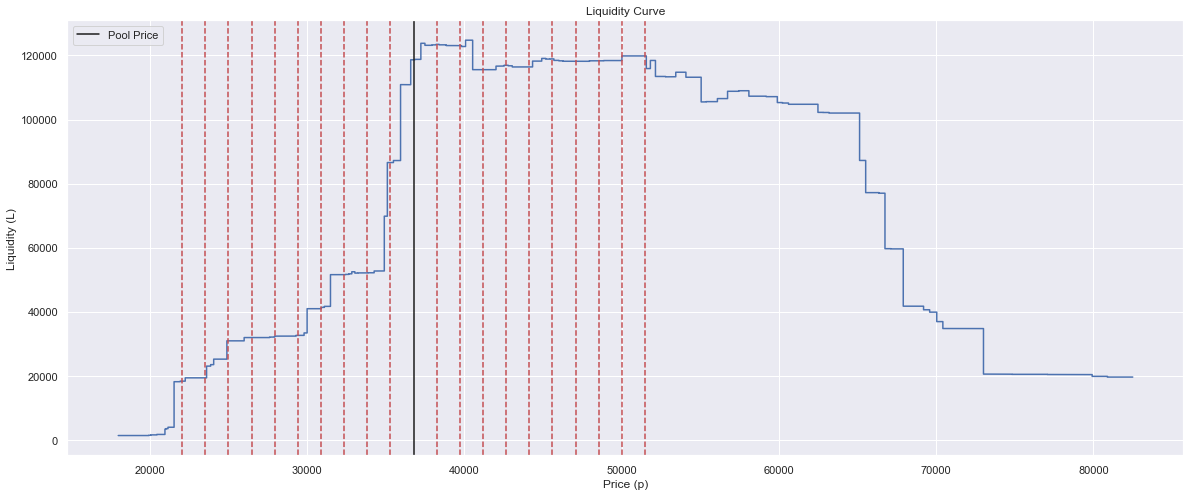

In [15]:
example_day = '2022-01-27'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(20000, 75000), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

In [16]:
%%time
numeraire_token = 1
sigma = 0.04
all_returns = {}

for day, start_pool in pool_snapshots.items():
    price_bins = np.array(
        [0]
        + [start_pool.price * (1 + i * sigma) for i in range(-10, 11)]
        + [np.inf]
    )
    day_txn = all_txn.loc[all_txn['txn_time'].dt.date == pd.to_datetime(day)]
    irrs = calc_irr_per_bin(start_pool, price_bins, day_txn, liquidity, swaps,
                            numeraire_token=numeraire_token, position_id='generic_LP')
    all_returns[day] = irrs
    
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)

CPU times: user 2min 42s, sys: 5.07 s, total: 2min 47s
Wall time: 2min 50s


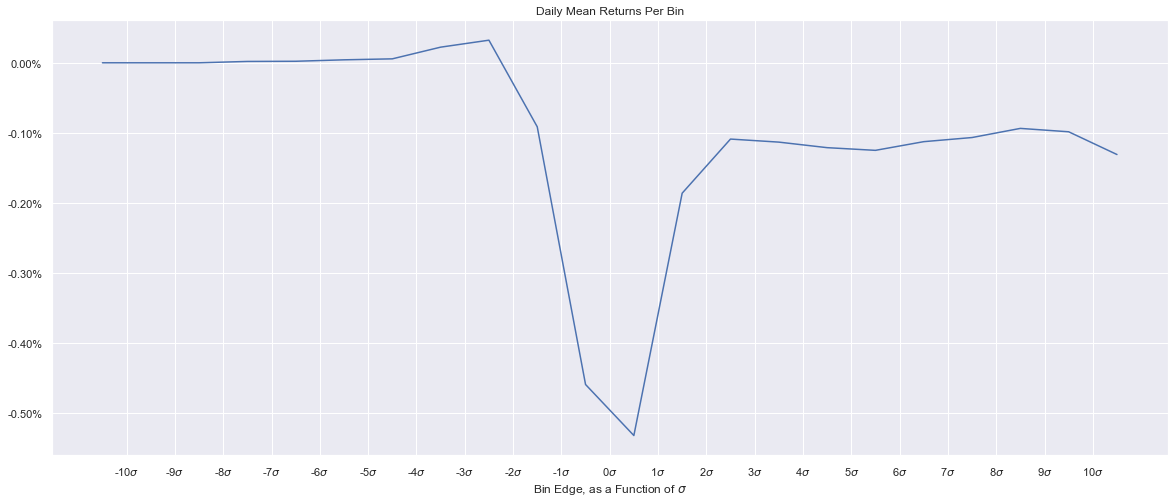

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [18]:
pd.to_pickle(all_returns, SAVED_RETURNS)